# ex057
2 output model


In [1]:
import gc
import os
import random
import time
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

# model
import torch
import torchvision
import torch.nn as nn
import timm
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms.functional as TF

# data loader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

# training
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, ExponentialLR, CyclicLR

# metric
from sklearn.metrics import fbeta_score, roc_auc_score

import wandb

import warnings
warnings.filterwarnings('ignore')

In [2]:
import yaml
exp_name = "exp058"
config_path = os.path.join("/working","output", exp_name, "Config.yaml")
with open(config_path, "r") as f:
    CFG = yaml.safe_load(f)
CFG["OUTPUT_DIR"] = os.path.join("/working","output", exp_name)
print(CFG)

# CFG["slide_pos_list"] = [[0,0]]

{'EXP_CATEGORY': 'SUBCLASS', 'INPUT_DIR': '/working/input/vesuvius-challenge-ink-detection', 'RANDOM_SLIDE': True, 'TRAIN_DIR': '/working/input/vesuvius-challenge-ink-detection/train', 'TRAIN_DIR_LIST': [['1', '2_0', '2_1', '2_2'], ['1', '2_0', '2_1', '3'], ['1', '2_0', '2_2', '3'], ['1', '2_1', '2_2', '3'], ['2_0', '2_1', '2_2', '3']], 'T_max': 5, 'VALID_DIR_LIST': [['3'], ['2_2'], ['2_1'], ['2_0'], ['1']], 'base_lr': 0.0001, 'batch_size': 8, 'folds': [0, 1, 2, 3, 4], 'img_size': [512, 512], 'inp_channels': 4, 'lr': 0.0002, 'max_lr': 0.0005, 'min_lr': 1e-08, 'model_name': 'tf_efficientnet_b6', 'channel_nums': [576, 200, 72, 40, 32], 'n_epoch': 15, 'num_workers': 2, 'out_channels': 1, 'out_indices': [0, 1, 2, 3, 4], 'pretrained': True, 'print_freq': 1000, 'random_seed': 21, 'slide_pos_list': [[0, 0], [256, 0], [0, 256], [256, 256]], 'step_size_down': 10, 'step_size_up': 5, 'SURFACE_LIST': [[26, 29, 32, 35], [27, 30, 33, 36], [25, 28, 31, 34]], 'surface_num': 4, 'weight_decay': 1e-06, '

# config

In [3]:
def seed_everything(seed=CFG["random_seed"]):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
    torch.backends.cudnn.benchmark = False
seed_everything()

# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# metric

In [5]:
def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta_auc(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    dice_list = [] 
    # for th in np.array(range(10, 50+1, 5)) / 100:
    for th in np.array(range(10, 100+1, 5)) / 100:
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice_list.append(dice)
        # print(f'\t th: {th}, fbeta: {dice}')
        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    auc = roc_auc_score(mask, mask_pred)
    # Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th, auc, dice_list


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th, auc, dice_list = calc_fbeta_auc(mask_gt, mask_pred)

    return best_dice, best_th, auc, dice_list

# model

In [6]:
class Encoder(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = timm.create_model(CFG["model_name"], in_chans=CFG["inp_channels"], 
                                         features_only=True, out_indices=CFG["out_indices"], pretrained=CFG["pretrained"])
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        return skip_connection_list

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.UpConv_0 = UpConv(CFG["channel_nums"][0], CFG["channel_nums"][1])
        self.UpConv_1 = UpConv(CFG["channel_nums"][1]*2, CFG["channel_nums"][2])
        self.UpConv_2 = UpConv(CFG["channel_nums"][2]*2, CFG["channel_nums"][3])
        self.UpConv_3 = UpConv(CFG["channel_nums"][3]*2, CFG["channel_nums"][4])
    def forward(self, skip_connection_list):
        emb = self.UpConv_0(skip_connection_list[4]) # emb.shape = (None, 160, 14, 14)
        emb_cat = torch.cat([skip_connection_list[3], emb], dim = 1)
        emb = self.UpConv_1(emb_cat)
        emb_cat = torch.cat([skip_connection_list[2], emb], dim = 1)
        emb = self.UpConv_2(emb_cat)
        emb_cat = torch.cat([skip_connection_list[1], emb], dim = 1)
        emb = self.UpConv_3(emb_cat)
        emb_cat = torch.cat([skip_connection_list[0], emb], dim = 1)
        return emb_cat

class SegModel(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = Encoder(CFG)
        self.decoder = Decoder(CFG)
        self.GAP = nn.AdaptiveAvgPool2d(output_size=(1))
        self.classifier = nn.Sequential(
            nn.Linear(CFG["channel_nums"][0], 1),
            nn.Sigmoid()
        )
        self.head = nn.Sequential(
            nn.Conv2d(CFG["channel_nums"][-1]*2, CFG["out_channels"], kernel_size=1, stride=1, padding=0),
        )
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        output_class = self.GAP(skip_connection_list[-1])
        output_class = output_class.view(-1, CFG["channel_nums"][0])
        output_class = self.classifier(output_class)
        emb = self.decoder(skip_connection_list)
        output_mask = self.head(emb)

        return output_class, output_mask



# Dataset

In [7]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomCrop(int(CFG["img_size"][0]*0.8), int(CFG["img_size"][1]*0.8), p=0.3),
    A.Blur(blur_limit=3, p=0.3),
    A.Resize(CFG["img_size"][0], CFG["img_size"][1]),
    ToTensorV2(),
])

valid_transforms = A.Compose([
    ToTensorV2(),
])

In [8]:
class VCID_Dataset(Dataset):
    def __init__(self, CFG, data_dir_list, surface_list, surface_volumes=None, slide_pos=[0,0], mode="train", transform=None):
        # get config
        self.mode = mode
        self.RANDOM_SLIDE = CFG["RANDOM_SLIDE"]
        self.img_size = CFG["img_size"]
        if self.mode=="train":  self.DATADIR = CFG["TRAIN_DIR"]
        elif self.mode=="valid":    self.DATADIR = CFG["TRAIN_DIR"]
        elif self.mode == "test":   self.DATADIR = CFG["TEST_DIR"]
        self.data_dir_list = data_dir_list
        self.surface_list = surface_list
        self.slide_pos = slide_pos
        self.transform = transform
        
        # get imgs
        # print("initializing dataset...")
        self.imgs = []
        for data_dir in self.data_dir_list:
            img_path = os.path.join(self.DATADIR, data_dir, "mask.png")
            # print(img_path)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = img.reshape(img.shape[0], img.shape[1], 1) # (h, w, channel=1)
            assert img is not None, "img is None. data path is wrong"
            self.imgs.append(img)  
        
        # get and split surface
        if surface_volumes is None:
            self.surface_vols = self.read_surfacevols()
        else:
            # print("using loaded surface_vols")
            self.surface_vols = surface_volumes
       
        # split grid
        self.get_all_grid()
        self.fileter_grid()
        self.get_flatten_grid()
        # print("split grid done.") 
       
        # get label imgs
        if self.mode == "train" or self.mode == "valid":
            self.labels = []
            for data_dir in self.data_dir_list:
                label_path = os.path.join(self.DATADIR, data_dir, "inklabels.png")
                assert os.path.exists(label_path), f"{label_path} is not exist."
                # read label
                label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                label = label.reshape(label.shape[0], label.shape[1], 1) # (h, w, channel=1)
                self.labels.append(label)# 画像サイズがそれぞれ違うので単純にconcatできずlist化しているs
        # print("initializing dataset done.")

    def get_surface_volumes(self):
        return self.surface_vols

    def read_surfacevols(self):
        """ read surface volume by data_dir_list and surface_list 
            Returns:surface_vuls (list): surface volume list [array(h,w,channel=surface_num), array(), ...]
        """
        surface_vols = []
        # print("reading surface volume...")
        for data_dir in self.data_dir_list:
            surface_vol_ = None
            for read_idx, surface_idx in enumerate(self.surface_list):
                # print("\r", f"reading idx : {read_idx+1}/{len(self.surface_list)}", end="")
                surface_path = os.path.join(self.DATADIR, data_dir, "surface_volume", f"{surface_idx:02}.tif")
                surface_vol = cv2.imread(surface_path, cv2.IMREAD_GRAYSCALE)
                surface_vol = surface_vol.reshape(surface_vol.shape[0], surface_vol.shape[1], 1) # (h, w, channel=1)
                if surface_vol_ is None:
                    surface_vol_ = surface_vol
                else:
                    surface_vol_ = np.concatenate([surface_vol_, surface_vol], axis=2) # (h, w, channel=surface_num)
            surface_vols.append(surface_vol_)
            # print(f"  => read surface volume done. [{data_dir}]")
        return surface_vols


    def get_grid_img(self, img, grid_idx):
        """ crop grid img from original img"""
        img_grid = img[(grid_idx[0]*self.img_size[0]) + self.slide_pos[0] : ((grid_idx[0]+1)*self.img_size[0]) + self.slide_pos[0],
                        (grid_idx[1]*self.img_size[1]) + self.slide_pos[1] : ((grid_idx[1]+1)*self.img_size[1]) + self.slide_pos[1]]
        return img_grid
    
    def get_grid_img_and_mask(self, img, mask, grid_idx):
        """ crop grid img from original img"""
        if self.RANDOM_SLIDE and self.mode=="train" and random.random() < 0.5:
            if (grid_idx[0]!=0 and grid_idx[1]!=0) and (grid_idx[0]!=img.shape[0]//self.img_size[0] and grid_idx[1]!=img.shape[1]//self.img_size[1]):
                rand_pos = [np.random.randint(0, self.img_size[0]//4) - self.img_size[0]//4, np.random.randint(0, self.img_size[1]//4)-self.img_size[1]//4]
            else:
                rand_pos = [0, 0]
        else:
            rand_pos = [0, 0]
        self.rand_pos = rand_pos
        img_grid = img[(grid_idx[0]*self.img_size[0]) + self.slide_pos[0] + rand_pos[0] : ((grid_idx[0]+1)*self.img_size[0]) + self.slide_pos[0] + rand_pos[0],
                        (grid_idx[1]*self.img_size[1]) + self.slide_pos[1] + rand_pos[1] : ((grid_idx[1]+1)*self.img_size[1]) + self.slide_pos[1] + rand_pos[1]]
        mask_grid = mask[(grid_idx[0]*self.img_size[0]) + self.slide_pos[0] + rand_pos[0] : ((grid_idx[0]+1)*self.img_size[0]) + self.slide_pos[0] + rand_pos[0],
                         (grid_idx[1]*self.img_size[1]) + self.slide_pos[1] + rand_pos[1] : ((grid_idx[1]+1)*self.img_size[1]) + self.slide_pos[1] + rand_pos[1]]
        return img_grid/255., mask_grid/255.
    
    def get_masked_img(self, img, mask):
        """ multiply mask to surface_volumes """
        masked_img = None
        for channel in range(img.shape[2]):
            img_channel = img[:,:,channel].reshape(img.shape[0], img.shape[1],1)
            masked = img_channel*mask
            if masked_img is None:
                masked_img = masked.reshape(masked.shape[0], masked.shape[1], 1)
            else:
                masked = masked.reshape(masked.shape[0], masked.shape[1], 1)
                masked_img = np.concatenate([masked_img, masked], axis=2)
        return masked_img
    
    
    def get_all_grid(self):
        """ get all grid indices by img size and grid size
        """
        self.grid_indices = []
        for img in self.imgs:
            self.x_grid_size = (img.shape[0] - self.slide_pos[0]) // self.img_size[0]
            self.y_grid_size = (img.shape[1] - self.slide_pos[1]) // self.img_size[1]
            grid_img = []
            for i in range(self.x_grid_size):
                for j in range(self.y_grid_size):
                    grid_img.append([i, j])
            self.grid_indices.append(grid_img)
        return self.grid_indices
          
    def fileter_grid(self):
        """ get grid indices which mask is not 0 by all grid indices"""
        grid_indices_all = []
        for img, grid_indices in zip(self.imgs, self.grid_indices):
            grid_indices_copy = grid_indices.copy()
            for grid_idx in grid_indices:
                img_grid = self.get_grid_img(img, grid_idx)
                if img_grid.sum() == 0:
                    grid_indices_copy.remove(grid_idx)
            grid_indices_all.append(grid_indices_copy)
        self.grid_indices = grid_indices_all
        return self.grid_indices

    def get_flatten_grid(self):
        """ get flatten index list by grid indices
            Returns:flatten_grid (list): flatten index list [[img_idx, grid_idx], [img_idx, grid_idx], ...]
        """
        flatten_grid = []
        for img_idx, grid_indices in enumerate(self.grid_indices):
            for grid_idx in grid_indices:
                grid_imgidx_list = [img_idx]
                grid_imgidx_list.extend(grid_idx)
                flatten_grid.append(grid_imgidx_list)
        self.flatten_grid = flatten_grid
        return self.flatten_grid
    
    def channel_shuffle(self, img):
        img = img.transpose(2, 0, 1)
        np.random.shuffle(img)
        return img.transpose(1, 2, 0)

    def __len__(self):
        return len(self.flatten_grid)

    def __getitem__(self, idx):
        # get indices
        img_grid_idx = self.flatten_grid[idx]
        img_idx = img_grid_idx[0]
        grid_idx = img_grid_idx[1:]
        # get img & surface_vol
        mask = self.imgs[img_idx]
        surface_vol = self.surface_vols[img_idx]
        # mask = self.get_grid_img(mask, grid_idx)/255.
        # surface_vol = self.get_grid_img(surface_vol, grid_idx)/255.
        mask, surface_vol = self.get_grid_img_and_mask(mask, surface_vol, grid_idx)
        # multiple small mask 
        assert surface_vol.shape[0]==mask.shape[0] and surface_vol.shape[1]==mask.shape[1] , "surface_vol_list shape is not same as img shape"
        img = surface_vol
        # transform
        if self.mode == "test":
            if self.transform:
                img = self.transform(image=img)["image"]
            else:
                img = img.transpose(2, 0, 1)
                img = torch.tensor(img, dtype=torch.float32)
            return img, grid_idx
        elif self.mode == "train" or self.mode=="valid":
            # get label(segmentation mask)
            label = self.labels[img_idx]
            label = self.get_grid_img(label, grid_idx)
            label_class = (np.sum(label) > 0).astype(np.int32)
            # if self.mode == "train":
            #     img = self.channel_shuffle(img)
            if self.transform:
                transformed = self.transform(image=img, mask=label)
                img = transformed["image"]
                label = transformed["mask"]
                label = label.permute(2, 0, 1)/255. # (channel, h, w)
                # label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            else:
                img = img.transpose(2, 0, 1) # (channel, h, w)
                label = label.transpose(2, 0, 1)/255. # (channel, h, w){}
                img = torch.tensor(img, dtype=torch.float32)
                label = torch.tensor(label, dtype=torch.float32)
                # label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            label_class = torch.tensor(label_class, dtype=torch.float32)
            assert img is not None and label is not None, f"img or label is None {img} {label}, {img_idx}, {grid_idx}, {self.rand_pos}"
            return img, label, label_class,grid_idx


In [9]:
# valid_dirs = CFG["VALID_DIR_LIST"][0]
# surface_list = SURFACE_LIST[0]
# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, mode="train")
# surface_volumes = dataset_notrans.surface_vols
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)

# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     if batch_idx < 2:
#         plt.figure(figsize=(20,5))
#         for channel in range(img.shape[2]):
#             plt.subplot(1, img.shape[2], channel+1)
#             plt.imshow(img[:,:,channel], cmap="gray")
#         plt.show()
#         [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
        
#     if batch_idx >= imshow_batch:
#         break    

# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])


In [10]:
# valid_dirs = CFG["VALID_DIR_LIST"][0]
# surface_list = SURFACE_LIST[0]
# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, mode="train")
# surface_volumes = dataset_notrans.surface_vols
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)

# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     if batch_idx < 2:
#         plt.figure(figsize=(20,5))
#         for channel in range(img.shape[2]):
#             plt.subplot(1, img.shape[2], channel+1)
#             plt.imshow(img[:,:,channel], cmap="gray")
#         plt.show()
#         [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
#     if batch_idx >= imshow_batch:
#         break    

# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])


In [11]:
# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, surface_volumes, slide_pos=[0,50],mode="train")
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)

# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     if batch_idx == 1:
#         plt.figure(figsize=(20,5))
#         for channel in range(img.shape[2]):
#             plt.subplot(1, img.shape[2], channel+1)
#             plt.imshow(img[:,:,channel], cmap="gray")
#         plt.show()
#         [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
#     if batch_idx >= imshow_batch:
#         break    

# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])


In [12]:
# valid_dirs = CFG["VALID_DIR_LIST"][0]
# surface_list = SURFACE_LIST[0]
# print("dataset")
# dataset_notrans = VCID_Dataset(CFG, valid_dirs, surface_list, mode="train", transform=train_transforms)
# print("dataloader")
# dataloader_notrans = DataLoader(dataset_notrans, 4, shuffle=False, num_workers=0)


# imshow_batch = 10

# for batch_idx, (imgs, labels, grid_idx) in enumerate(dataloader_notrans):
#     img = imgs[0].permute(1, 2, 0)
#     if batch_idx == 0:
#         plt.figure(figsize=(20,5))
#         for channel in range(img.shape[2]):
#             plt.subplot(1, img.shape[2], channel+1)
#             plt.imshow(img[:,:,channel], cmap="gray")
#         plt.show()
#         [print(np.max(img[:,:,idx].numpy())) for idx in range(img.shape[2])]
#     if batch_idx >= imshow_batch:
#         break    

# img_hist, img_bins = np.histogram(np.array(img[:,:,0]).flatten())
# plt.figure()
# plt.plot(img_hist)
# plt.show()
# print(img[:,:,0])

# Loss

In [13]:
#PyTorch
ALPHA = 0.1 # < 0.5 penalises FP more, > 0.5 penalises FN more
CE_RATIO = 0.90 #weighted contribution of modified CE loss compared to Dice loss

class ComboLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(ComboLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, eps=1e-9):
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        intersection = (inputs * targets).sum()    
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        
        inputs = torch.clamp(inputs, eps, 1.0 - eps)       
        out = - (ALPHA * ((targets * torch.log(inputs)) + ((1 - ALPHA) * (1.0 - targets) * torch.log(1.0 - inputs))))
        weighted_ce = out.mean(-1)
        # if dice is None or dice > 0:
        #     combo = weighted_ce
        # else:
        #     combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)
        combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)
        assert combo is not None, f"combo loss is None, weighted_ce: {weighted_ce}, dice: {dice}"
        return combo

# train valid fn

In [14]:
def valid_fn(model, valid_loader, criterion=None):
    model.eval()# モデルを検証モードに設定
    test_targets_mask, test_preds_mask = [], []
    test_targets_class, test_preds_class = [], []
    test_grid_idx = []
    batch_time = AverageMeter()
    losses = AverageMeter()
    start = end = time.time()
    for batch_idx, (images, targets_mask, targets_class, grid_idx) in enumerate(valid_loader):
        images = images.to(device, non_blocking = True).float()
        targets_mask = targets_mask.to(device, non_blocking = True).float()
        targets_class = targets_class.to(device, non_blocking = True).float().view(-1, 1)
        with torch.no_grad():
            preds_class, preds_mask = model(images)
            preds_mask = TF.resize(img=preds_mask, size=(CFG["img_size"][0], CFG["img_size"][1]))
            assert preds_mask is not None, f"preds_mask is None, {preds_mask}, {images}, {targets_mask}"
            assert preds_class is not None, f"preds_class is None, {preds_class}, {images}, {targets_class}"
            if not criterion is None:
                loss = criterion(preds_class, targets_class, preds_mask, targets_mask)
                assert loss is not None, f"loss is None, {loss}, {images}, {targets_mask}, {targets_class}"
            preds_mask = torch.sigmoid(preds_mask)
        if not criterion is None:
            losses.update(loss.item(), CFG["batch_size"])
        batch_time.update(time.time() - end)

        targets_mask = targets_mask.detach().cpu().numpy()
        preds_mask = preds_mask.detach().cpu().numpy()
        targets_class = targets_class.detach().cpu().numpy().ravel().tolist()
        preds_class = preds_class.detach().cpu().numpy().ravel().tolist()
        
        test_preds_mask.extend([preds_mask[idx, :,:,:].transpose(1,2,0) for idx in range(preds_mask.shape[0])])
        test_targets_mask.extend([targets_mask[idx, :,:,:].transpose(1,2,0) for idx in range(targets_mask.shape[0])])
        test_preds_class.extend(preds_class)
        test_targets_class.extend(targets_class)
        
        test_grid_idx.extend([[x_idx, y_idx] for x_idx, y_idx in zip(grid_idx[0].tolist(), grid_idx[1].tolist())])

        if (batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(valid_loader)-1)) and (not criterion is None):
            print('EVAL: [{0}/{1}] '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                    batch_idx, len(valid_loader), batch_time=batch_time, loss=losses,
                    remain=timeSince(start, float(batch_idx+1)/len(valid_loader)),
                ))
        del images, preds_class, preds_mask, targets_mask, targets_class
        gc.collect()
        torch.cuda.empty_cache()
    if criterion is None:
        return test_targets_mask, test_preds_mask, test_targets_class, test_preds_class, test_grid_idx
    else:
        return test_targets_mask, test_preds_mask, test_targets_class, test_preds_class, test_grid_idx, losses.avg



In [15]:
def concat_grid_img(img_list, label_list, grid_idx_list, valid_dir_list, slide_pos=[0,0]):
    # concat pred img and label to original size
    img_path = os.path.join(CFG["TRAIN_DIR"], valid_dir_list[0], "mask.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape(img.shape[0], img.shape[1], 1)
    pred_img = np.zeros_like(img).astype(np.float32)
    label_img = np.zeros_like(img).astype(np.float32)
    for img_idx, grid_idx in enumerate(grid_idx_list):
        pred_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += img_list[img_idx]
        
        label_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += label_list[img_idx]
    return pred_img, label_img

In [16]:
def concat_grid_img_withclass(img_list, class_list, label_list, grid_idx_list, valid_dir_list, CFG, slide_pos=[0,0]):
    # concat pred img and label to original size
    img_path = os.path.join(CFG["TRAIN_DIR"], valid_dir_list[0], "mask.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape(img.shape[0], img.shape[1], 1)
    pred_img = np.zeros_like(img).astype(np.float32)
    label_img = np.zeros_like(img).astype(np.float32)
    for img_idx, grid_idx in enumerate(grid_idx_list):
        class_pred = class_list[img_idx]
        if class_pred >= 0.9:
            pred_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                     grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += img_list[img_idx]*1.2
        elif class_pred >= 0.2:
            pred_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                     grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += img_list[img_idx]
        label_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += label_list[img_idx]
        
    return pred_img, label_img

In [17]:
def concat_grid_img_tta(img_list, label_list, grid_idx_list, valid_dir_list, slide_pos=[0,0], tta="default"):
    # concat pred img and label to original size
    img_path = os.path.join(CFG["TRAIN_DIR"], valid_dir_list[0], "mask.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape(img.shape[0], img.shape[1], 1)
    pred_img = np.zeros_like(img).astype(np.float32)
    label_img = np.zeros_like(img).astype(np.float32)
    for img_idx, grid_idx in enumerate(grid_idx_list):
        if tta=="default":
            pred_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                    grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += img_list[img_idx]
            label_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                    grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += label_list[img_idx]
        elif tta=="vflip":
            pred_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                    grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += np.flipud(img_list[img_idx])
            label_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                    grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += np.flipud(label_list[img_idx])
        elif tta=="hflip":
            pred_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                    grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += np.fliplr(img_list[img_idx])
            label_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                    grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += np.fliplr(label_list[img_idx])

    return pred_img, label_img

In [18]:
def create_class_grid_img_tta(img_list, class_list, grid_idx_list, valid_dir_list, slide_pos=[0,0]):
    # concat pred img and label to original size
    img_path = os.path.join(CFG["TRAIN_DIR"], valid_dir_list[0], "mask.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape(img.shape[0], img.shape[1], 1)
    pred_img = np.zeros_like(img).astype(np.float32)
    for img_idx, grid_idx in enumerate(grid_idx_list):
        class_pred_img = np.ones_like(img_list[img_idx]).astype(np.float32)*class_list[img_idx]
        pred_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += class_pred_img
        
    return pred_img

In [19]:
def save_and_plot_oof(mode, fold, slice_idx, valid_preds_img, valid_targets_img, valid_preds_binary, CFG):
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_{mode}_slice{slice_idx}_valid_pred_img.png"), valid_preds_img*255)
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_{mode}_slice{slice_idx}_valid_predbin_img.png"), valid_preds_binary*255)
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_{mode}_slice{slice_idx}_valid_targets_img.png"), valid_targets_img*255)
    
    # plot preds & binary preds
    plt.figure(dpi=100)
    plt.subplot(1,3,1)
    plt.imshow(valid_preds_img)
    plt.subplot(1,3,2)
    plt.imshow(valid_preds_binary)
    plt.subplot(1,3,3)
    plt.imshow(valid_targets_img)
    plt.show()
                

In [20]:
def save_and_plot_oof_withclass(mode, fold, slice_idx, valid_preds_img, valid_preds_img_class, valid_targets_img, valid_preds_binary, CFG):
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_{mode}_slice{slice_idx}_valid_pred_img.png"), valid_preds_img*255)
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_{mode}_slice{slice_idx}_valid_pred_img.png"), valid_preds_img_class*255)
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_{mode}_slice{slice_idx}_valid_predbin_img.png"), valid_preds_binary*255)
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_{mode}_slice{slice_idx}_valid_targets_img.png"), valid_targets_img*255)
    
    # plot preds & binary preds
    plt.figure(dpi=100)
    plt.subplot(1,4,1)
    plt.imshow(valid_preds_img)
    plt.subplot(1,4,2)
    plt.imshow(valid_preds_binary)
    plt.subplot(1,4,3)
    plt.imshow(valid_preds_img_class)
    plt.subplot(1,4,4)
    plt.imshow(valid_targets_img)
    plt.show()
                

# slice inference

In [29]:
def get_tta_aug(aug_type):
    if aug_type=="default":
        return A.Compose([ToTensorV2(),])
    elif aug_type=="hflip":
        return A.Compose([
            A.HorizontalFlip(p=1.0),
            ToTensorV2(),
        ])
    elif aug_type=="vflip":
        return A.Compose([
            A.VerticalFlip(p=1.0),
            ToTensorV2(),
        ])
    else:
        return A.Compose([ToTensorV2(),])
        

In [30]:
def slide_inference(CFG, tta_list):
    start_time = time.time()
    slice_ave_score_list, slice_ave_auc_list, slice_ave_score_threshold_list = [], [], []
    for fold in CFG["folds"]:
        print(f"-- fold{fold} slide inference start --")
 
        # set model & learning fn
        model = SegModel(CFG)
        # model_path = os.path.join(CFG["OUTPUT_DIR"], f'{CFG["model_name"]}_fold{fold}.pth')
        model_path = os.path.join(CFG["OUTPUT_DIR"], f'{CFG["model_name"]}_auc_fold{fold}.pth')
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        valid_img_slice = None
        valid_img_class_slice = None
        for slice_idx, surface_list in enumerate(CFG["SURFACE_LIST"]):
            print(f"surface_list: {surface_list}")
            surface_volumes = None
            for slide_pos in CFG["slide_pos_list"]:
                print(f"slide pos:{slide_pos}")
                for tta in tta_list:
                    valid_dirs = CFG["VALID_DIR_LIST"][fold]
                    valid_transforms = get_tta_aug(tta)
                    valid_dataset = VCID_Dataset(CFG, valid_dirs, surface_list, surface_volumes, slide_pos, mode="valid", transform=valid_transforms)
                    surface_volumes = valid_dataset.get_surface_volumes()
                    valid_loader = DataLoader(valid_dataset, batch_size=CFG["batch_size"], shuffle = False,
                                                num_workers = CFG["num_workers"], pin_memory = True)

                    valid_targets, valid_preds, valid_targets_class, valid_preds_class, valid_grid_idx = valid_fn(model, valid_loader)
                    plt.figure(dpi=50)
                    plt.hist(valid_preds_class, bins=50)
                    plt.show()
                    # raise Exception()
                    # target, predをconcatして元のサイズに戻す
                    # valid_preds_img, valid_targets_img  = concat_grid_img_withclass(valid_preds, valid_preds_class, valid_targets, valid_grid_idx, valid_dirs, CFG,slide_pos)
                    valid_preds_img, valid_targets_img = concat_grid_img_tta(valid_preds, valid_targets, valid_grid_idx, valid_dirs, slide_pos, tta)
                    valid_img_class = create_class_grid_img_tta(valid_preds, valid_preds_class, valid_grid_idx, valid_dirs, slide_pos)
                    valid_score, valid_threshold, auc, dice_list = calc_cv(valid_targets_img, valid_preds_img)
                    valid_preds_binary = (valid_preds_img > valid_threshold).astype(np.uint8)
                    # save_and_plot_oof("oof_class", fold, slice_idx, valid_preds_img, valid_targets_img, valid_preds_binary, CFG)
                    save_and_plot_oof_withclass("oof_class", fold, slice_idx, valid_preds_img, valid_img_class, valid_targets_img, valid_preds_binary, CFG)
                    auc_class = roc_auc_score(valid_targets_class, valid_preds_class, average="macro")
                    elapsed = time.time() - start_time
                    print(f"\t score:{valid_score:.4f}(th={valid_threshold:3f}), auc={auc:4f}, auc class={auc_class:4f} ::: time:{elapsed:.2f}s")
                    # valid_img_slice.append(valid_preds_img)
                    if valid_img_slice is None:
                        valid_img_slice = valid_preds_img
                        valid_img_class_slice = valid_img_class
                    else:
                        valid_img_slice += valid_preds_img
                        valid_img_class_slice += valid_img_class
        valid_img_slice /= len(["SURFACE_LIST"])*len(CFG["slide_pos_list"])*len(tta_list)
        valid_img_class_slice /= len(["SURFACE_LIST"])*len(CFG["slide_pos_list"])*len(tta_list)
        valid_sliceave_score, valid_sliceave_threshold, ave_auc, dice_list = calc_cv(valid_targets_img, valid_img_slice)
        
        slice_ave_score_list.append(valid_sliceave_score)
        slice_ave_auc_list.append(ave_auc)
        slice_ave_score_threshold_list.append(valid_sliceave_threshold)

        valid_slice_binary = (valid_img_slice > valid_sliceave_threshold).astype(np.uint8)
        # save_and_plot_oof("average_tta", fold, 555, valid_img_slice, valid_targets_img, valid_slice_binary, CFG)
        save_and_plot_oof_withclass("average_tta", fold, 555, valid_img_slice, valid_img_class_slice, valid_targets_img, valid_slice_binary, CFG)
        print(f'[fold{fold}] slice ave score:{valid_sliceave_score:.4f}(th={valid_sliceave_threshold:3f}), auc={ave_auc:4f}')
         
        del model, valid_loader, valid_dataset, valid_preds_img, valid_targets_img, valid_preds_binary
        gc.collect()
        torch.cuda.empty_cache()
    return slice_ave_score_list, slice_ave_auc_list, slice_ave_score_threshold_list



---
# OOF SCORE INFER

-- fold0 slide inference start --
surface_list: [26, 29, 32, 35]
slide pos:[0, 0]


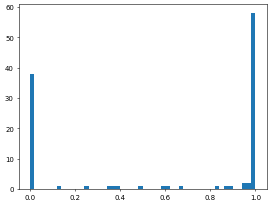

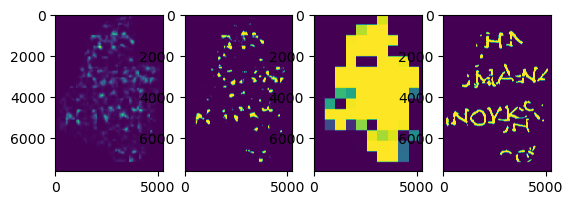

	 score:0.5135(th=0.200000), auc=0.885995, auc class=0.843883 ::: time:31.20s


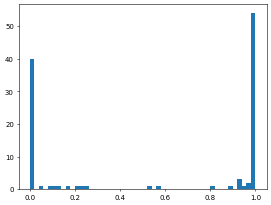

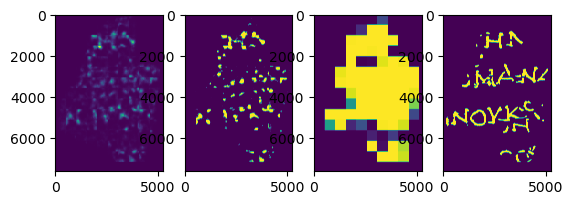

	 score:0.5073(th=0.150000), auc=0.883329, auc class=0.861664 ::: time:49.58s


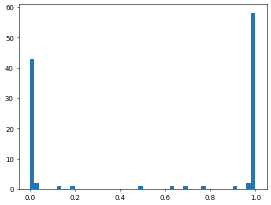

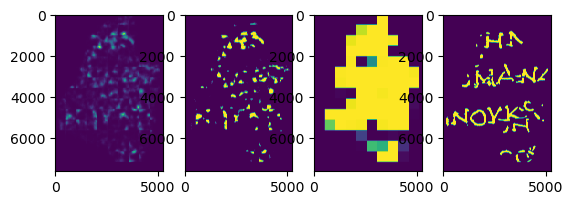

	 score:0.4880(th=0.150000), auc=0.876983, auc class=0.837482 ::: time:67.74s
slide pos:[256, 0]


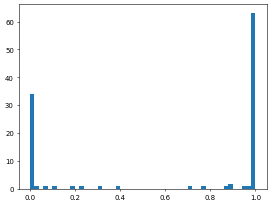

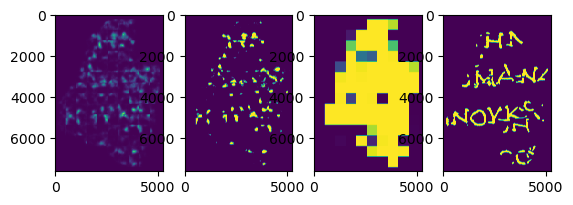

	 score:0.5019(th=0.200000), auc=0.880095, auc class=0.791667 ::: time:86.68s


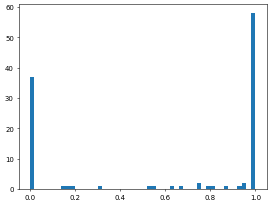

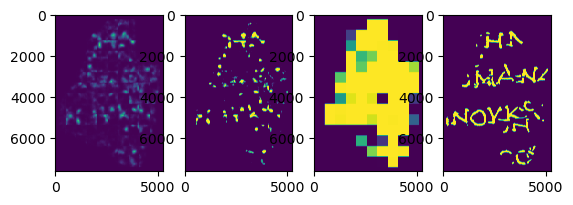

	 score:0.4901(th=0.200000), auc=0.876276, auc class=0.809117 ::: time:104.84s


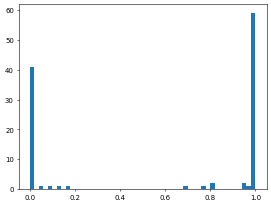

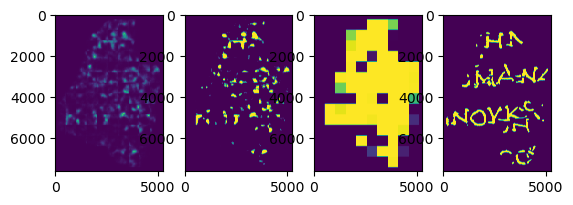

	 score:0.4660(th=0.150000), auc=0.869173, auc class=0.779915 ::: time:123.06s
slide pos:[0, 256]


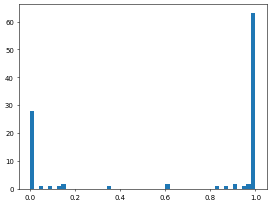

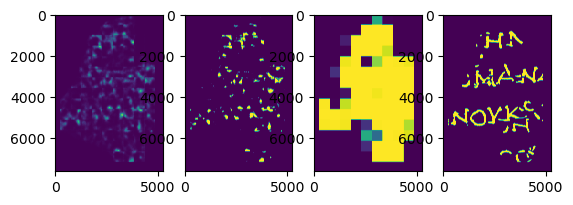

	 score:0.4848(th=0.200000), auc=0.887084, auc class=0.811540 ::: time:141.16s


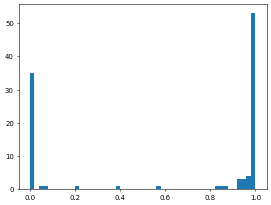

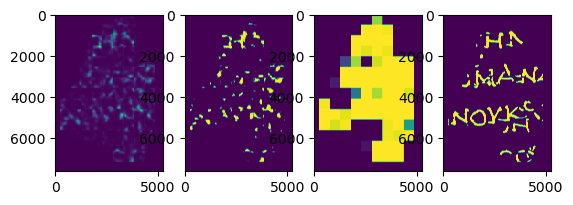

	 score:0.4956(th=0.150000), auc=0.884209, auc class=0.830220 ::: time:159.20s


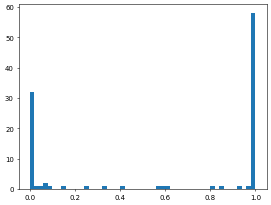

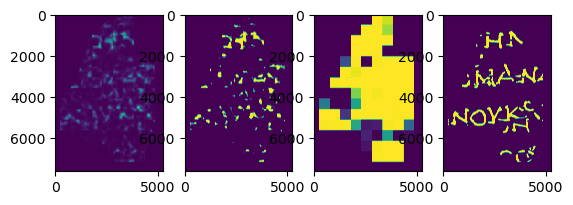

	 score:0.4816(th=0.150000), auc=0.884438, auc class=0.802823 ::: time:177.30s
slide pos:[256, 256]


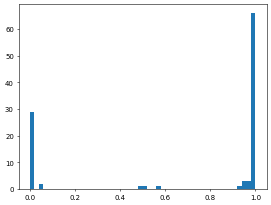

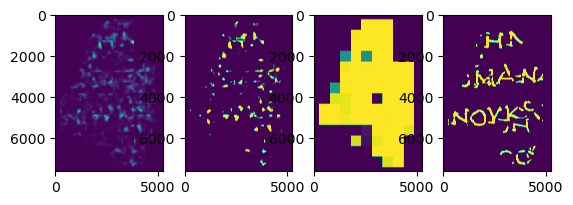

	 score:0.4695(th=0.200000), auc=0.884311, auc class=0.734479 ::: time:195.64s


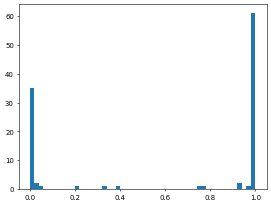

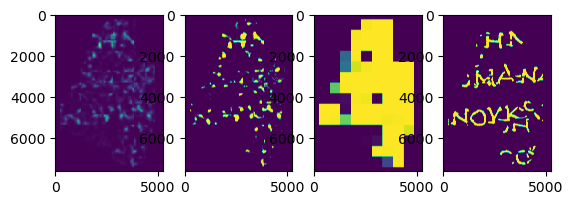

	 score:0.4777(th=0.150000), auc=0.882010, auc class=0.751293 ::: time:213.65s


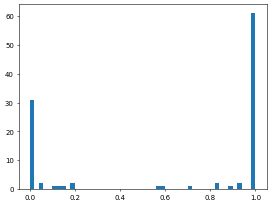

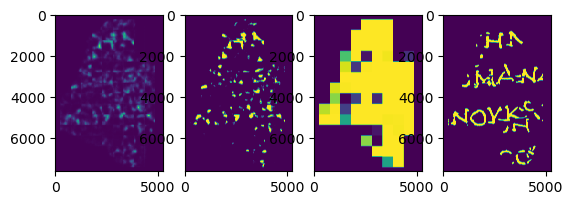

	 score:0.4809(th=0.150000), auc=0.877883, auc class=0.751663 ::: time:231.80s
surface_list: [27, 30, 33, 36]
slide pos:[0, 0]


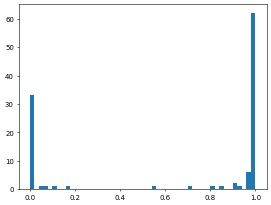

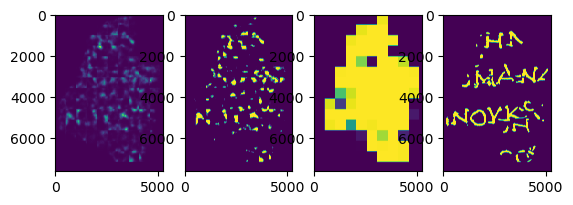

	 score:0.5079(th=0.150000), auc=0.883544, auc class=0.845306 ::: time:258.00s


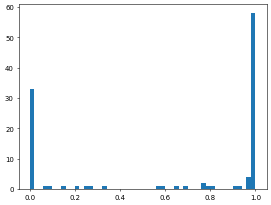

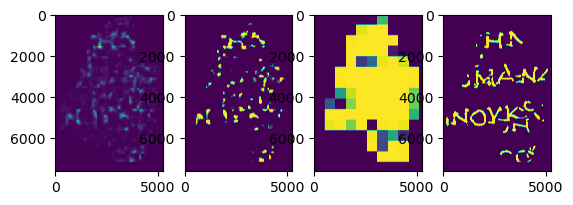

	 score:0.4993(th=0.150000), auc=0.879596, auc class=0.853129 ::: time:276.43s


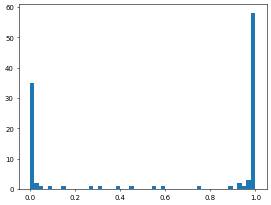

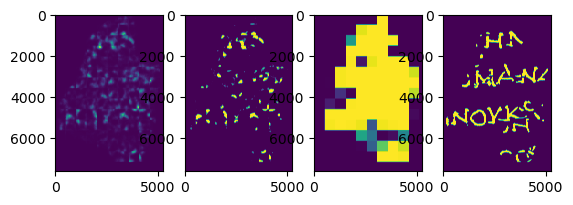

	 score:0.4873(th=0.200000), auc=0.877237, auc class=0.824858 ::: time:295.03s
slide pos:[256, 0]


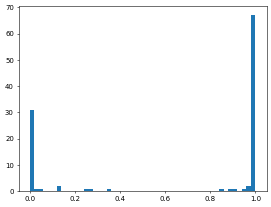

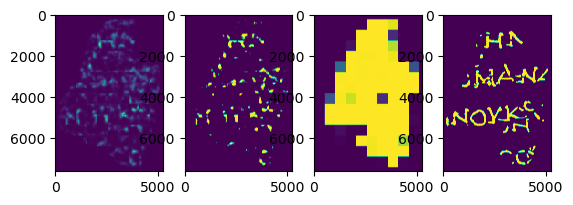

	 score:0.4882(th=0.200000), auc=0.873258, auc class=0.788105 ::: time:313.15s


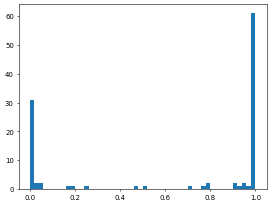

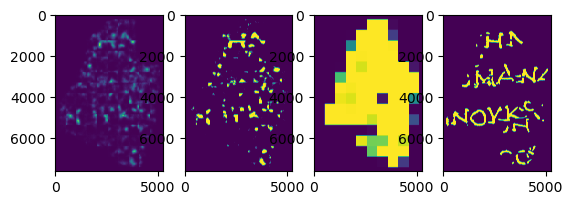

	 score:0.4870(th=0.150000), auc=0.872326, auc class=0.797365 ::: time:331.17s


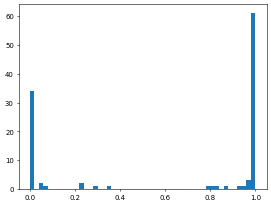

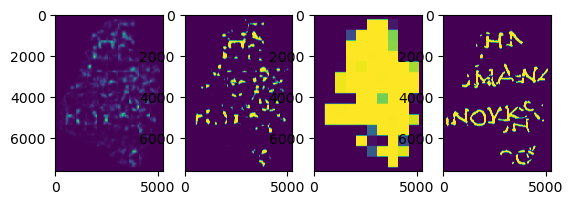

	 score:0.4754(th=0.150000), auc=0.868315, auc class=0.796652 ::: time:349.37s
slide pos:[0, 256]


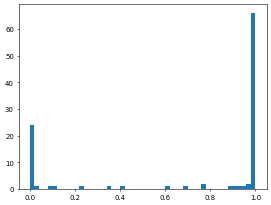

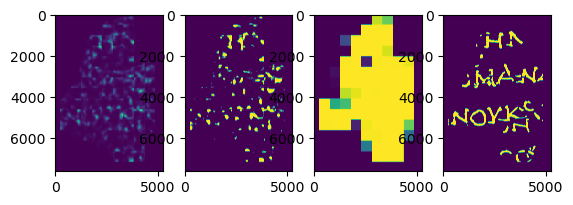

	 score:0.4647(th=0.150000), auc=0.884009, auc class=0.809880 ::: time:367.14s


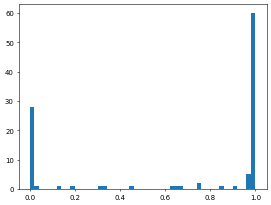

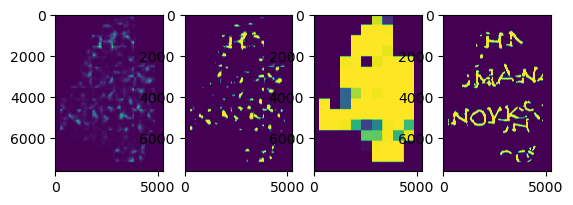

	 score:0.4815(th=0.150000), auc=0.880601, auc class=0.811955 ::: time:385.26s


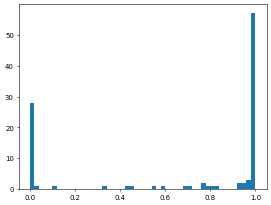

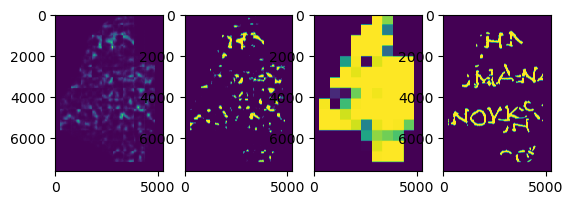

	 score:0.4769(th=0.150000), auc=0.882191, auc class=0.801162 ::: time:403.21s
slide pos:[256, 256]


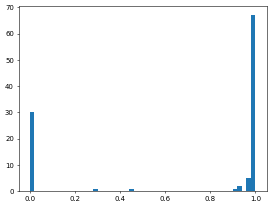

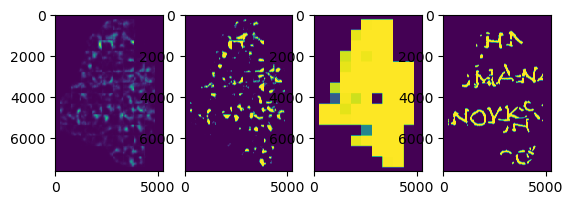

	 score:0.4612(th=0.150000), auc=0.878869, auc class=0.726534 ::: time:421.67s


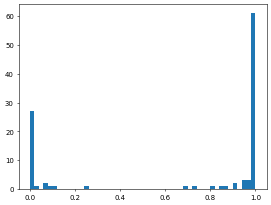

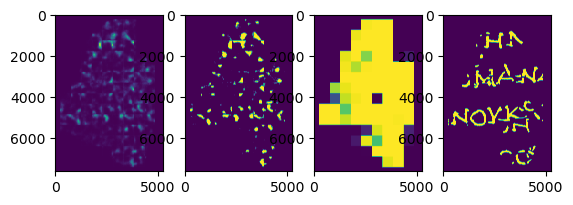

	 score:0.4670(th=0.150000), auc=0.878252, auc class=0.728197 ::: time:439.76s


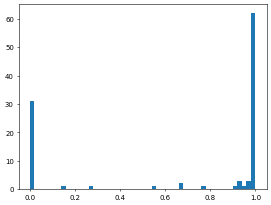

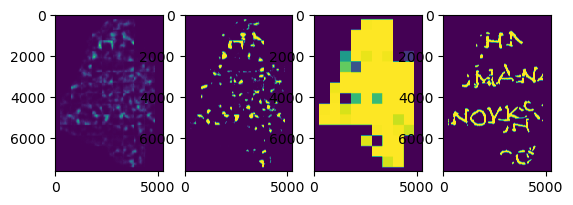

	 score:0.4769(th=0.150000), auc=0.875425, auc class=0.759424 ::: time:457.59s
surface_list: [25, 28, 31, 34]
slide pos:[0, 0]


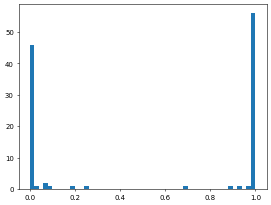

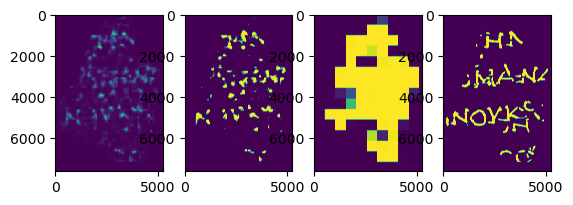

	 score:0.4964(th=0.150000), auc=0.889306, auc class=0.844239 ::: time:484.98s


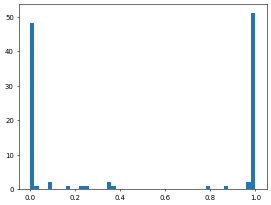

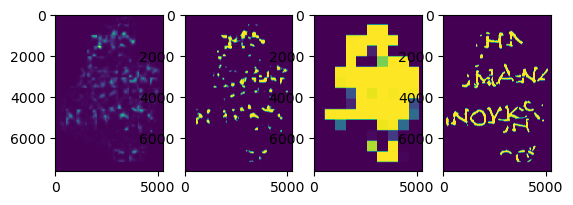

	 score:0.4983(th=0.150000), auc=0.889743, auc class=0.855263 ::: time:503.57s


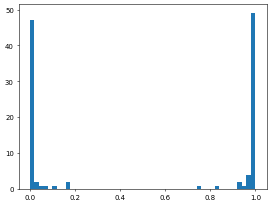

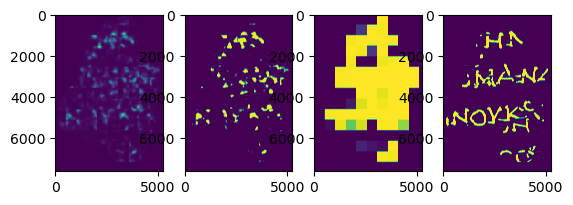

	 score:0.4853(th=0.150000), auc=0.882183, auc class=0.840327 ::: time:521.99s
slide pos:[256, 0]


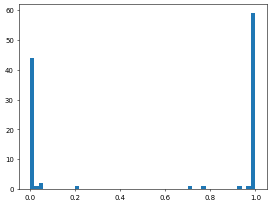

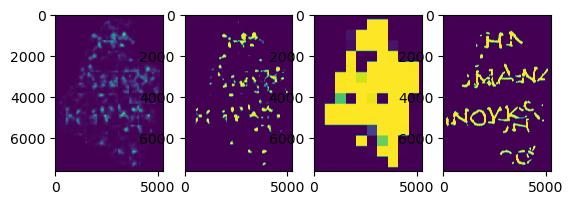

	 score:0.4900(th=0.200000), auc=0.882000, auc class=0.796652 ::: time:540.60s


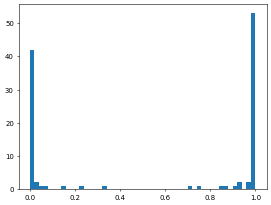

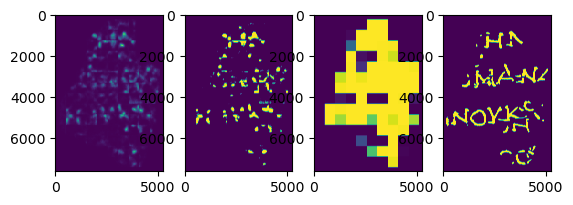

	 score:0.4822(th=0.150000), auc=0.880315, auc class=0.818020 ::: time:559.09s


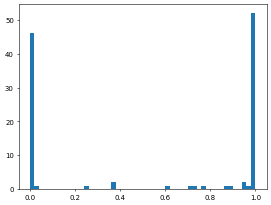

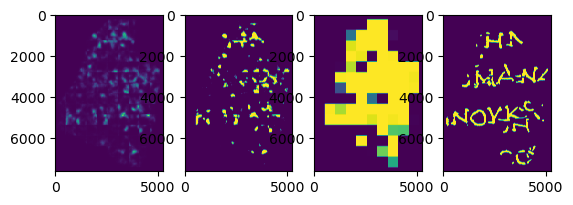

	 score:0.4701(th=0.150000), auc=0.875420, auc class=0.781695 ::: time:577.39s
slide pos:[0, 256]


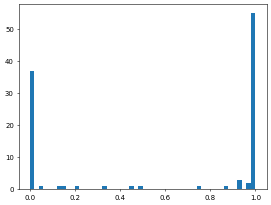

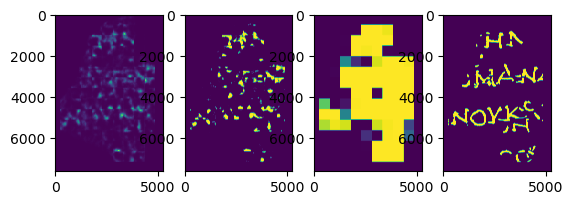

	 score:0.4942(th=0.150000), auc=0.890030, auc class=0.824408 ::: time:595.48s


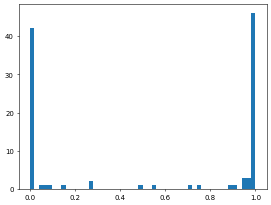

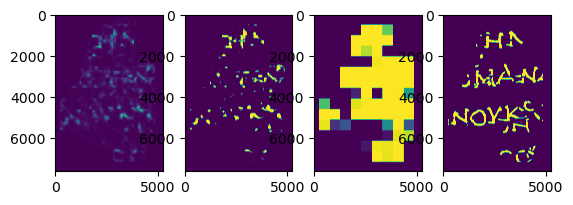

	 score:0.5139(th=0.150000), auc=0.890987, auc class=0.835201 ::: time:613.47s


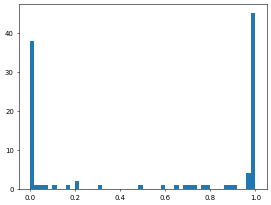

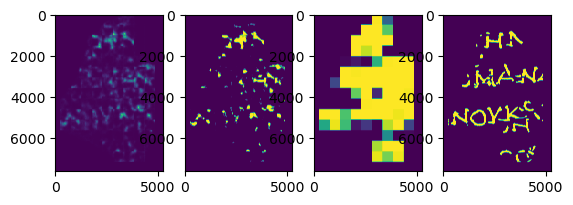

	 score:0.4892(th=0.150000), auc=0.886636, auc class=0.813616 ::: time:631.49s
slide pos:[256, 256]


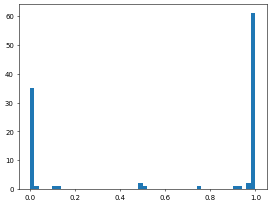

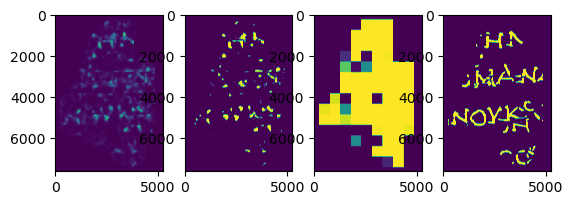

	 score:0.4838(th=0.200000), auc=0.889472, auc class=0.745381 ::: time:649.67s


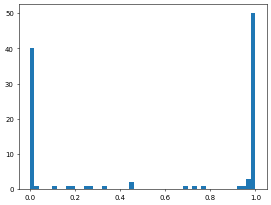

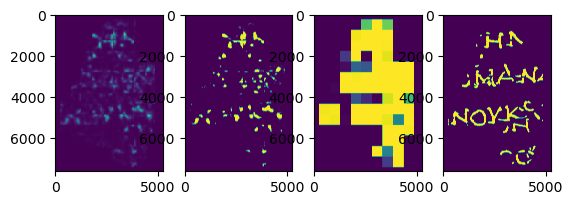

	 score:0.4926(th=0.150000), auc=0.887007, auc class=0.777162 ::: time:667.63s


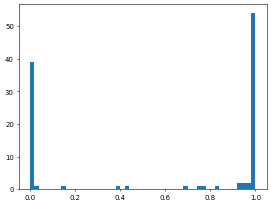

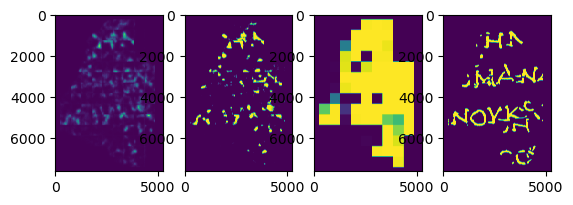

	 score:0.4954(th=0.150000), auc=0.883704, auc class=0.766814 ::: time:686.14s


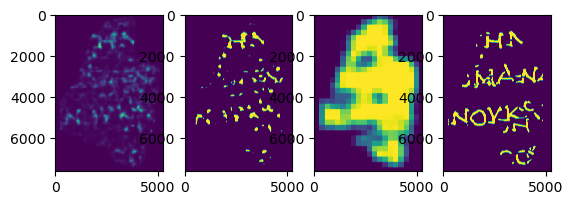

[fold0] slice ave score:0.5754(th=0.450000), auc=0.906707
-- fold1 slide inference start --
surface_list: [26, 29, 32, 35]
slide pos:[0, 0]


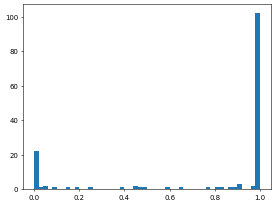

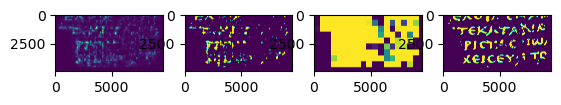

	 score:0.5028(th=0.200000), auc=0.822208, auc class=0.778446 ::: time:730.17s


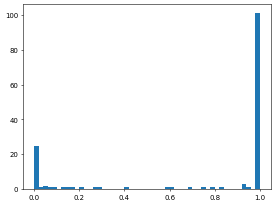

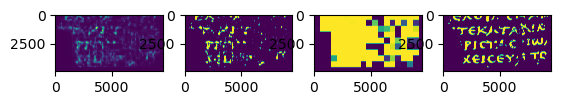

	 score:0.5067(th=0.200000), auc=0.817604, auc class=0.784461 ::: time:753.29s


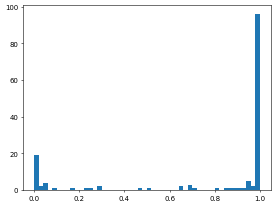

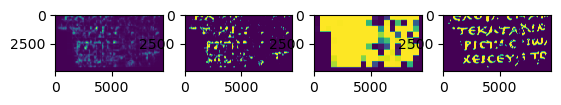

	 score:0.4831(th=0.200000), auc=0.822608, auc class=0.791980 ::: time:776.93s
slide pos:[256, 0]


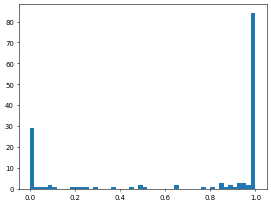

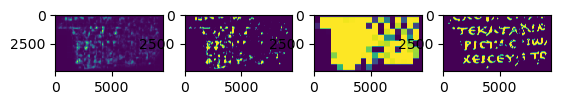

	 score:0.4682(th=0.200000), auc=0.821101, auc class=0.841406 ::: time:800.31s


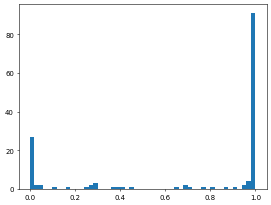

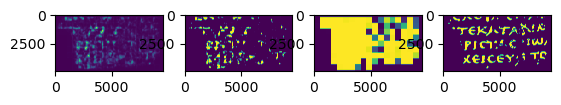

	 score:0.4728(th=0.200000), auc=0.828933, auc class=0.803906 ::: time:823.66s


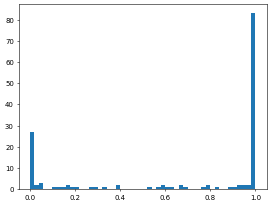

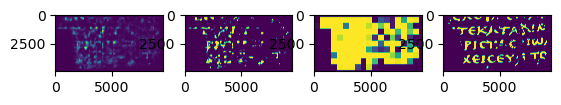

	 score:0.4688(th=0.200000), auc=0.827799, auc class=0.823828 ::: time:847.07s
slide pos:[0, 256]


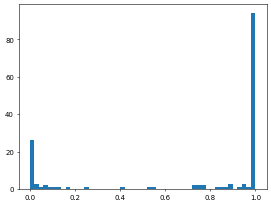

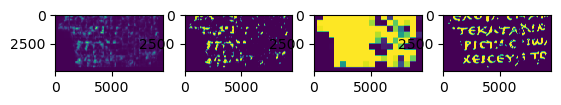

	 score:0.4985(th=0.200000), auc=0.812543, auc class=0.734314 ::: time:871.27s


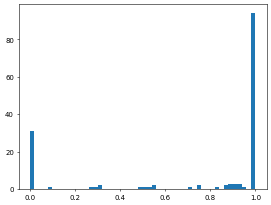

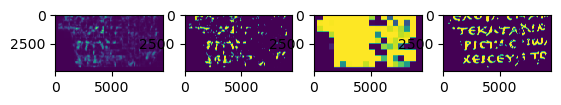

	 score:0.4925(th=0.200000), auc=0.811745, auc class=0.752451 ::: time:894.88s


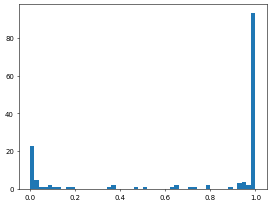

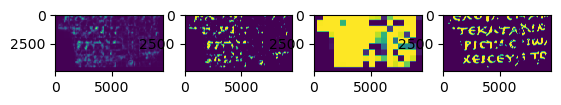

	 score:0.4864(th=0.200000), auc=0.815287, auc class=0.771078 ::: time:918.62s
slide pos:[256, 256]


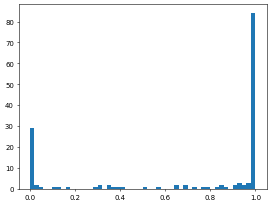

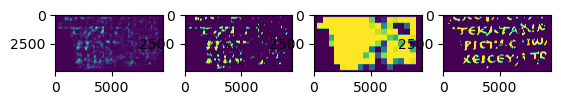

	 score:0.4632(th=0.200000), auc=0.817900, auc class=0.808077 ::: time:942.17s


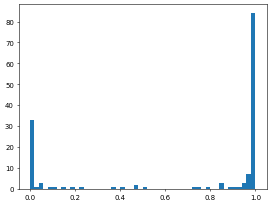

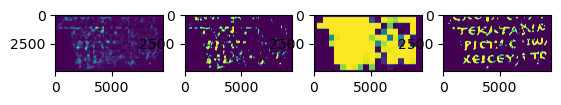

	 score:0.4804(th=0.200000), auc=0.821315, auc class=0.790000 ::: time:965.71s


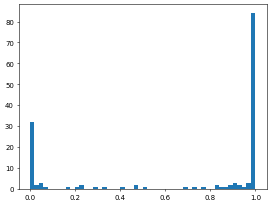

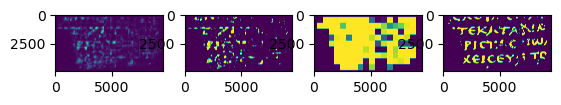

	 score:0.4781(th=0.200000), auc=0.817049, auc class=0.760962 ::: time:989.04s
surface_list: [27, 30, 33, 36]
slide pos:[0, 0]


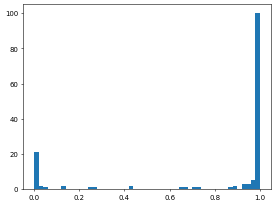

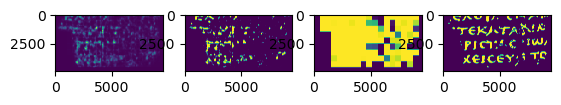

	 score:0.5246(th=0.200000), auc=0.833066, auc class=0.788972 ::: time:1017.01s


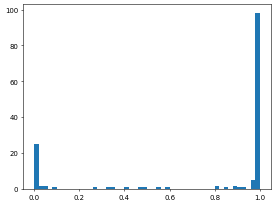

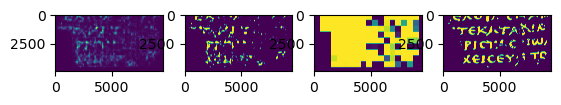

	 score:0.5257(th=0.200000), auc=0.826512, auc class=0.794486 ::: time:1040.22s


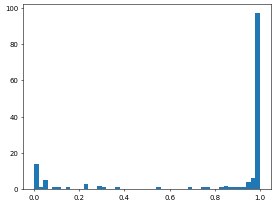

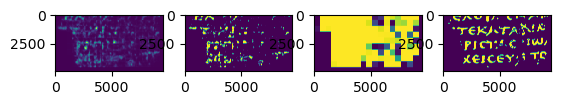

	 score:0.4859(th=0.200000), auc=0.826524, auc class=0.784461 ::: time:1063.68s
slide pos:[256, 0]


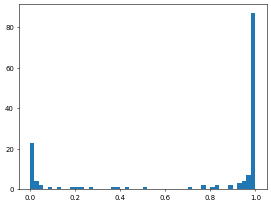

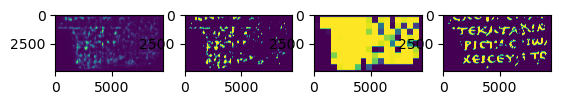

	 score:0.4889(th=0.200000), auc=0.833336, auc class=0.850000 ::: time:1086.91s


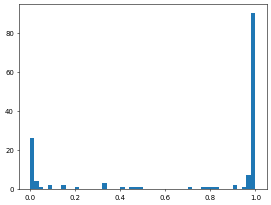

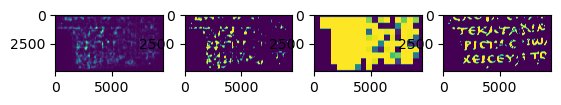

	 score:0.4955(th=0.200000), auc=0.837345, auc class=0.825391 ::: time:1110.17s


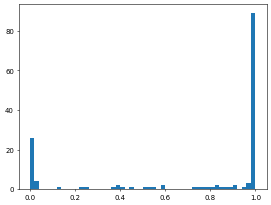

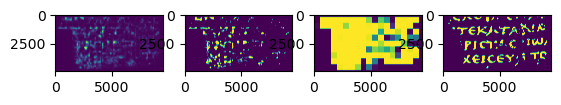

	 score:0.4661(th=0.200000), auc=0.833448, auc class=0.835547 ::: time:1133.72s
slide pos:[0, 256]


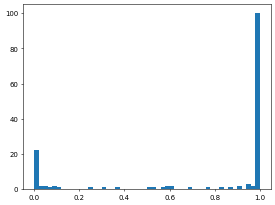

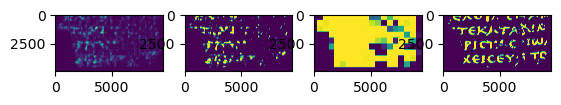

	 score:0.5159(th=0.200000), auc=0.822400, auc class=0.760784 ::: time:1157.11s


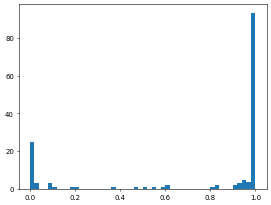

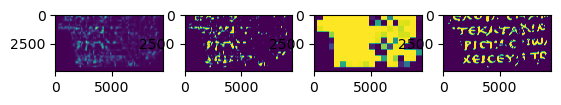

	 score:0.5045(th=0.200000), auc=0.820352, auc class=0.778922 ::: time:1181.14s


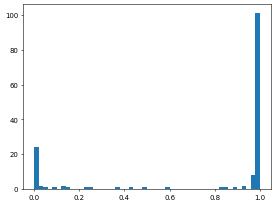

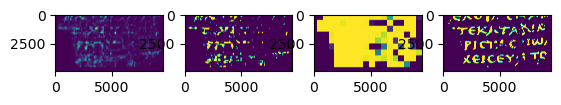

	 score:0.4889(th=0.200000), auc=0.817110, auc class=0.780882 ::: time:1204.99s
slide pos:[256, 256]


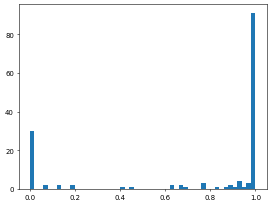

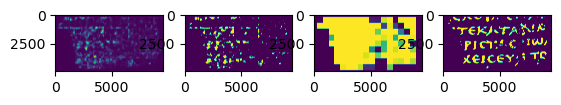

	 score:0.4873(th=0.200000), auc=0.828091, auc class=0.803462 ::: time:1228.46s


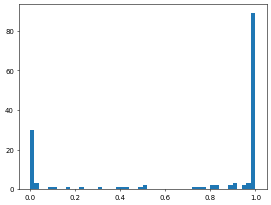

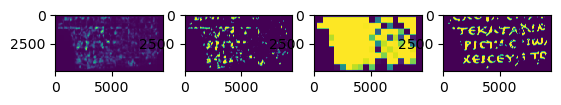

	 score:0.4881(th=0.200000), auc=0.832021, auc class=0.800000 ::: time:1252.00s


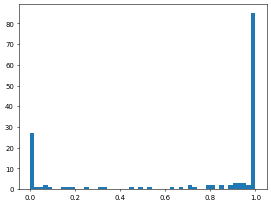

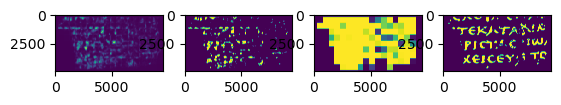

	 score:0.4736(th=0.200000), auc=0.823172, auc class=0.774808 ::: time:1275.83s
surface_list: [25, 28, 31, 34]
slide pos:[0, 0]


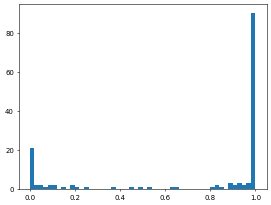

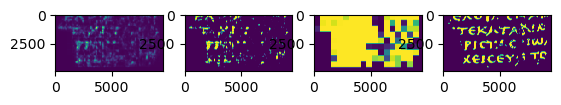

	 score:0.4791(th=0.200000), auc=0.816977, auc class=0.762406 ::: time:1304.40s


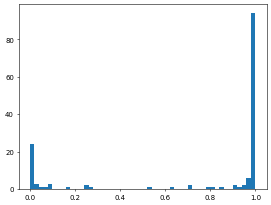

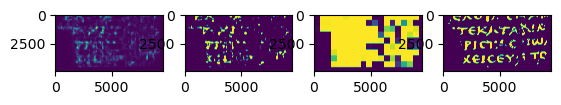

	 score:0.4896(th=0.200000), auc=0.814402, auc class=0.762907 ::: time:1328.68s


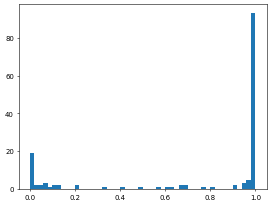

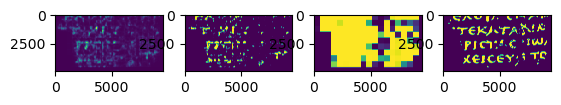

	 score:0.4821(th=0.200000), auc=0.816757, auc class=0.779449 ::: time:1352.40s
slide pos:[256, 0]


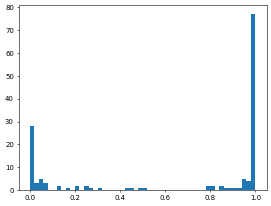

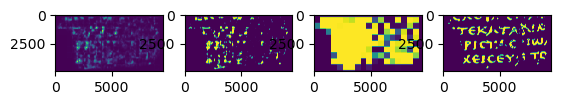

	 score:0.4438(th=0.200000), auc=0.819288, auc class=0.840234 ::: time:1376.28s


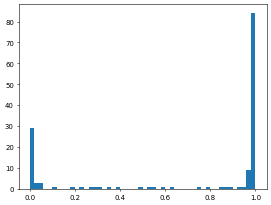

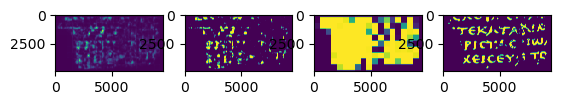

	 score:0.4691(th=0.200000), auc=0.824481, auc class=0.817187 ::: time:1399.60s


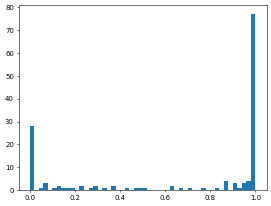

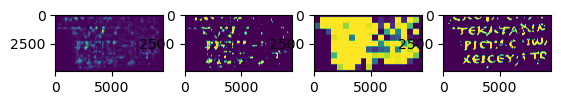

	 score:0.4644(th=0.200000), auc=0.823563, auc class=0.819922 ::: time:1423.45s
slide pos:[0, 256]


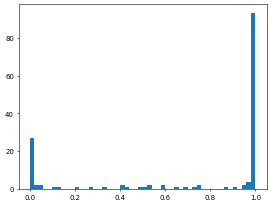

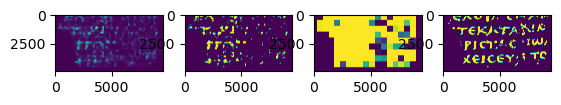

	 score:0.4742(th=0.200000), auc=0.811490, auc class=0.732353 ::: time:1447.12s


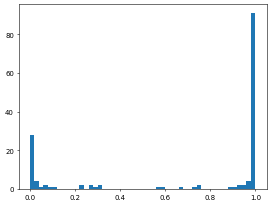

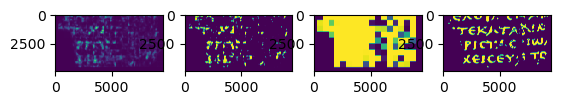

	 score:0.4866(th=0.200000), auc=0.809731, auc class=0.739706 ::: time:1471.21s


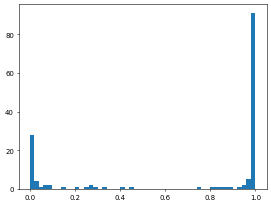

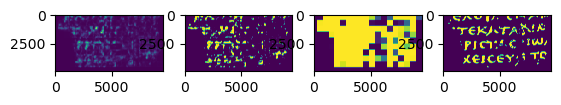

	 score:0.4783(th=0.150000), auc=0.815975, auc class=0.755882 ::: time:1494.83s
slide pos:[256, 256]


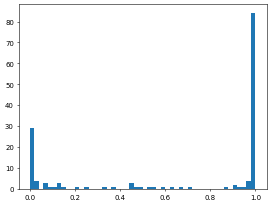

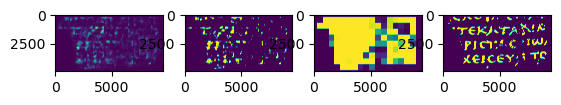

	 score:0.4387(th=0.200000), auc=0.813903, auc class=0.796154 ::: time:1518.07s


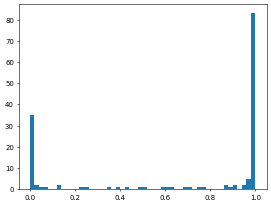

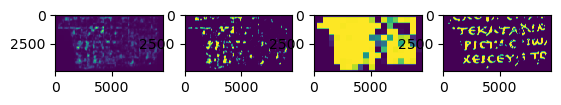

	 score:0.4631(th=0.200000), auc=0.814813, auc class=0.777308 ::: time:1541.65s


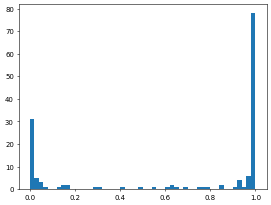

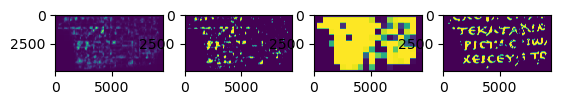

	 score:0.4662(th=0.200000), auc=0.817220, auc class=0.759231 ::: time:1565.20s


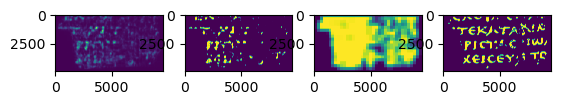

[fold1] slice ave score:0.5223(th=0.600000), auc=0.842096
-- fold2 slide inference start --
surface_list: [26, 29, 32, 35]
slide pos:[0, 0]


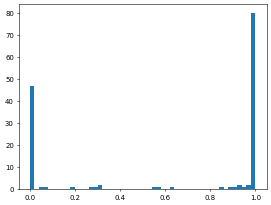

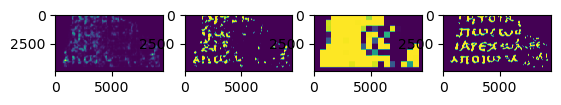

	 score:0.4755(th=0.150000), auc=0.832866, auc class=0.827068 ::: time:1612.16s


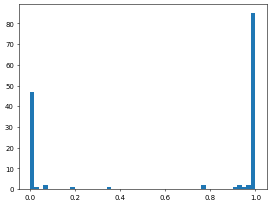

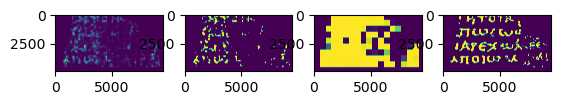

	 score:0.4872(th=0.200000), auc=0.831430, auc class=0.828321 ::: time:1634.88s


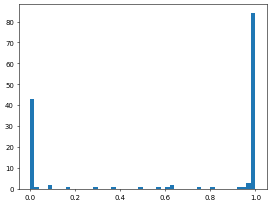

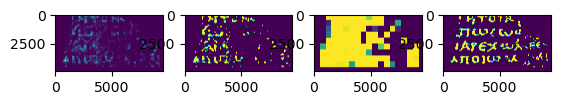

	 score:0.5030(th=0.150000), auc=0.838999, auc class=0.806809 ::: time:1657.62s
slide pos:[256, 0]


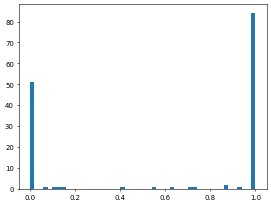

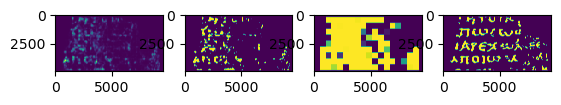

	 score:0.4684(th=0.150000), auc=0.824575, auc class=0.810658 ::: time:1680.47s


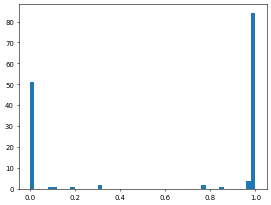

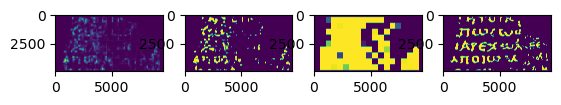

	 score:0.4712(th=0.150000), auc=0.831628, auc class=0.790249 ::: time:1703.34s


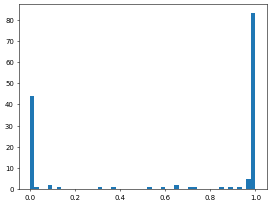

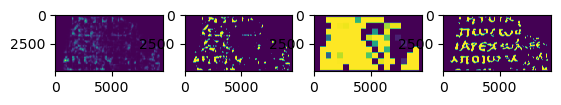

	 score:0.4758(th=0.150000), auc=0.826641, auc class=0.813681 ::: time:1726.13s
slide pos:[0, 256]


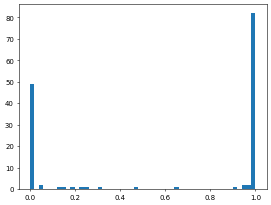

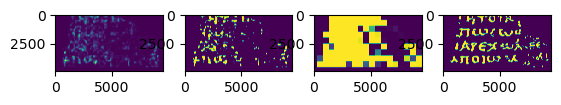

	 score:0.4954(th=0.150000), auc=0.834803, auc class=0.896033 ::: time:1748.76s


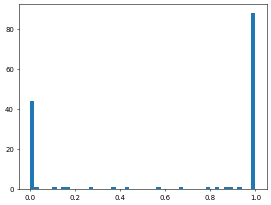

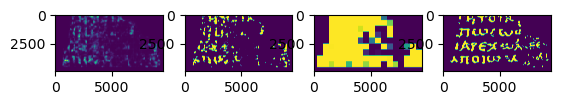

	 score:0.5083(th=0.150000), auc=0.835522, auc class=0.885089 ::: time:1771.92s


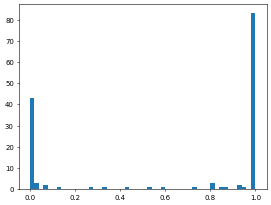

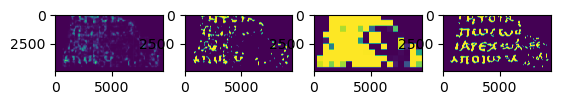

	 score:0.5261(th=0.150000), auc=0.840189, auc class=0.892841 ::: time:1794.62s
slide pos:[256, 256]


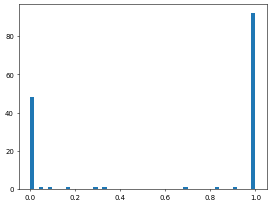

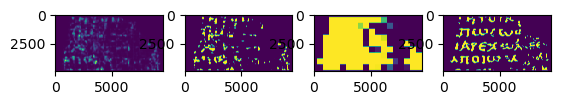

	 score:0.4740(th=0.150000), auc=0.824087, auc class=0.829771 ::: time:1817.46s


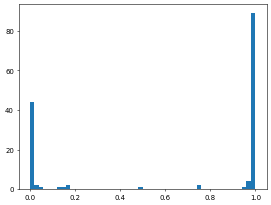

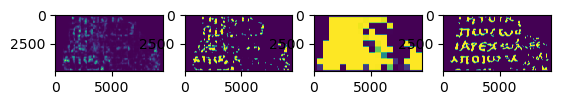

	 score:0.4979(th=0.150000), auc=0.829308, auc class=0.845144 ::: time:1840.24s


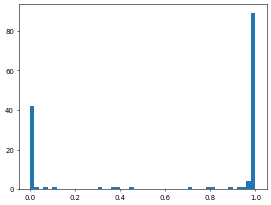

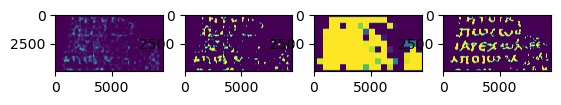

	 score:0.4913(th=0.150000), auc=0.829773, auc class=0.846457 ::: time:1863.14s
surface_list: [27, 30, 33, 36]
slide pos:[0, 0]


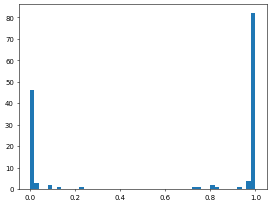

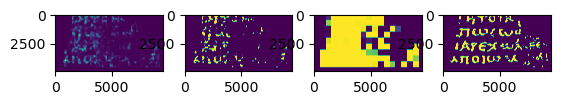

	 score:0.4792(th=0.200000), auc=0.835296, auc class=0.829992 ::: time:1890.50s


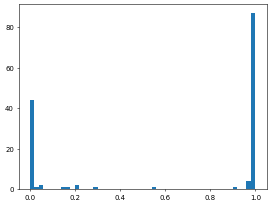

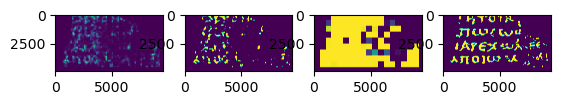

	 score:0.4728(th=0.200000), auc=0.832959, auc class=0.827068 ::: time:1913.21s


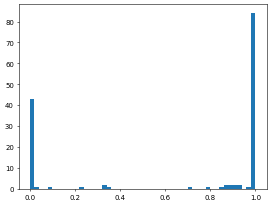

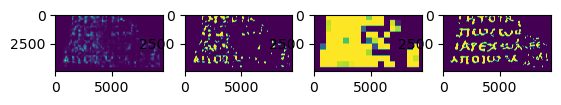

	 score:0.5080(th=0.150000), auc=0.839680, auc class=0.807644 ::: time:1935.89s
slide pos:[256, 0]


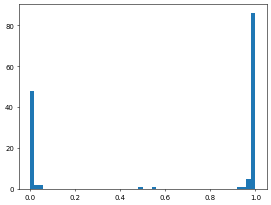

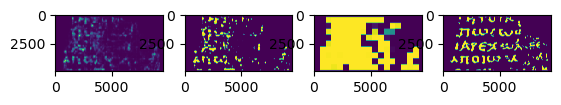

	 score:0.4858(th=0.150000), auc=0.828788, auc class=0.806878 ::: time:1958.50s


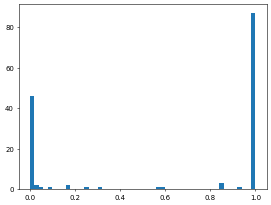

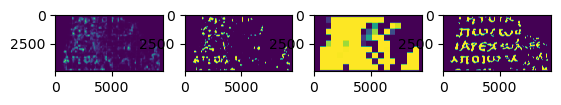

	 score:0.4736(th=0.200000), auc=0.832973, auc class=0.791761 ::: time:1981.75s


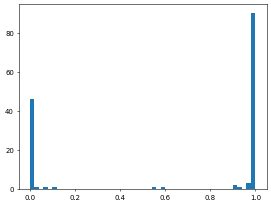

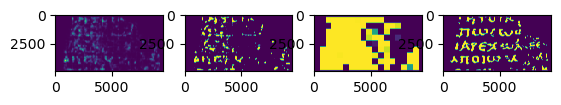

	 score:0.4746(th=0.150000), auc=0.824987, auc class=0.813114 ::: time:2004.79s
slide pos:[0, 256]


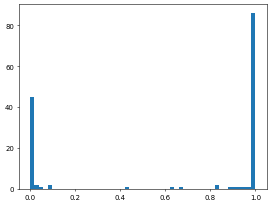

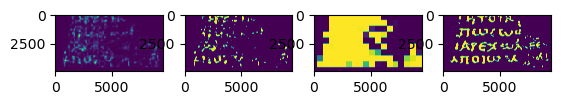

	 score:0.5106(th=0.200000), auc=0.837423, auc class=0.887825 ::: time:2027.71s


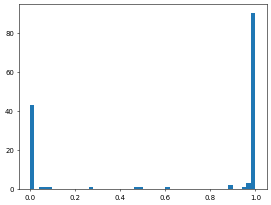

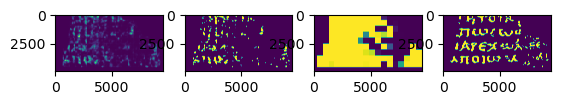

	 score:0.5066(th=0.200000), auc=0.835911, auc class=0.866849 ::: time:2050.95s


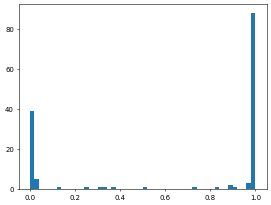

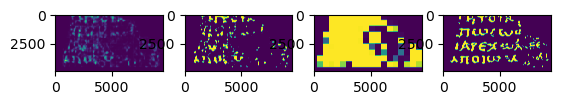

	 score:0.5163(th=0.150000), auc=0.841943, auc class=0.898769 ::: time:2074.09s
slide pos:[256, 256]


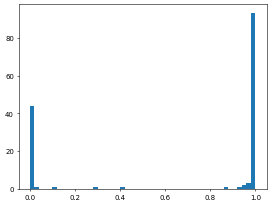

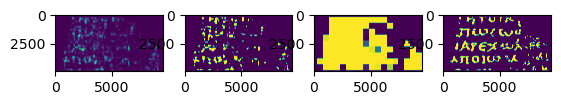

	 score:0.4788(th=0.150000), auc=0.829251, auc class=0.823022 ::: time:2096.84s


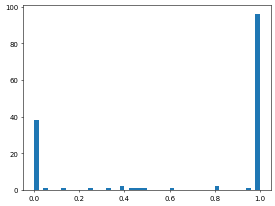

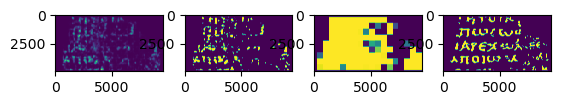

	 score:0.4876(th=0.150000), auc=0.828823, auc class=0.828646 ::: time:2120.14s


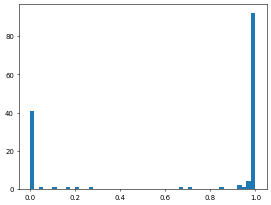

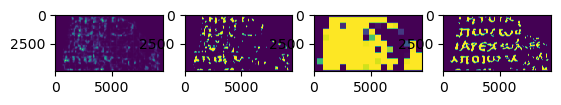

	 score:0.4912(th=0.150000), auc=0.828212, auc class=0.825834 ::: time:2142.70s
surface_list: [25, 28, 31, 34]
slide pos:[0, 0]


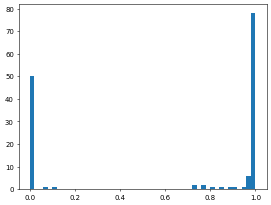

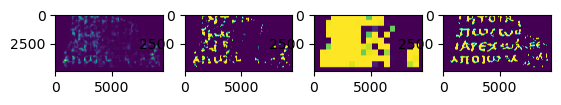

	 score:0.4741(th=0.150000), auc=0.830377, auc class=0.824144 ::: time:2169.96s


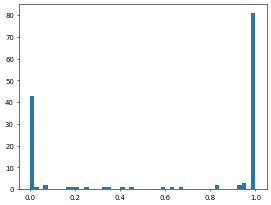

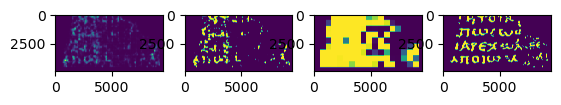

	 score:0.4733(th=0.150000), auc=0.824971, auc class=0.827068 ::: time:2192.81s


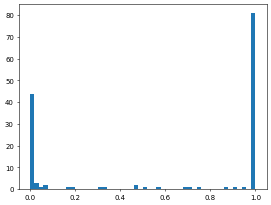

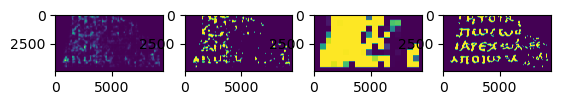

	 score:0.4741(th=0.150000), auc=0.829927, auc class=0.809733 ::: time:2215.63s
slide pos:[256, 0]


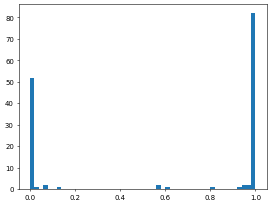

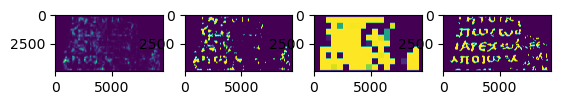

	 score:0.4473(th=0.150000), auc=0.820844, auc class=0.828420 ::: time:2238.41s


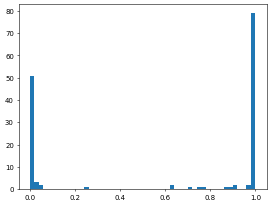

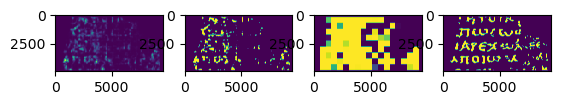

	 score:0.4547(th=0.150000), auc=0.824822, auc class=0.784392 ::: time:2261.27s


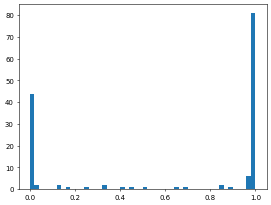

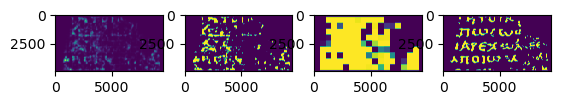

	 score:0.4550(th=0.100000), auc=0.821313, auc class=0.788738 ::: time:2284.21s
slide pos:[0, 256]


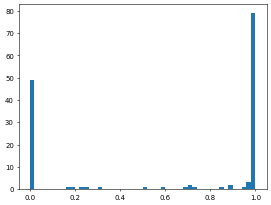

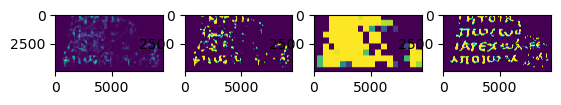

	 score:0.4742(th=0.150000), auc=0.827534, auc class=0.878705 ::: time:2306.89s


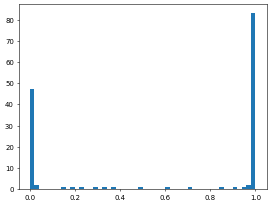

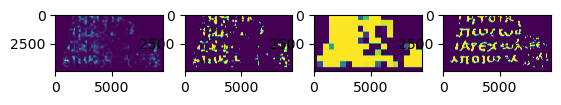

	 score:0.4959(th=0.150000), auc=0.827585, auc class=0.881441 ::: time:2329.79s


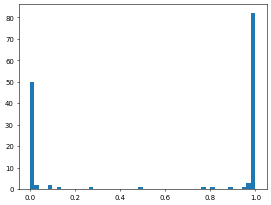

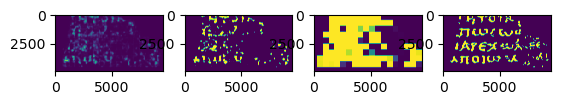

	 score:0.5124(th=0.150000), auc=0.834075, auc class=0.894209 ::: time:2352.80s
slide pos:[256, 256]


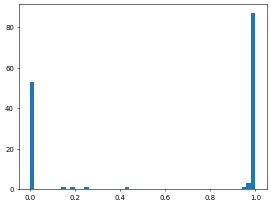

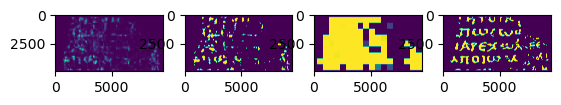

	 score:0.4684(th=0.150000), auc=0.820201, auc class=0.848144 ::: time:2376.49s


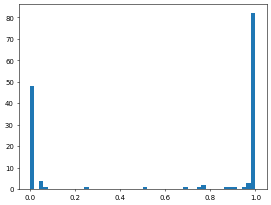

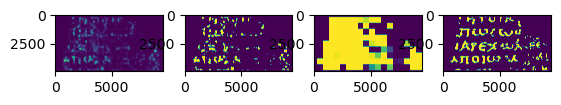

	 score:0.4892(th=0.150000), auc=0.825257, auc class=0.873266 ::: time:2399.55s


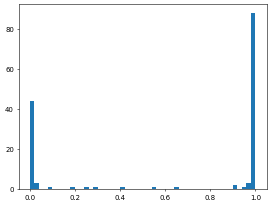

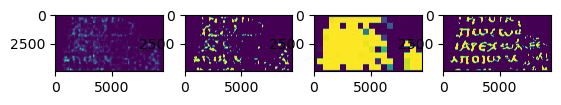

	 score:0.4802(th=0.150000), auc=0.822168, auc class=0.841020 ::: time:2422.60s


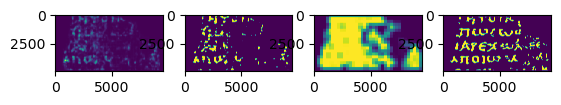

[fold2] slice ave score:0.5191(th=0.450000), auc=0.845156
-- fold3 slide inference start --
surface_list: [26, 29, 32, 35]
slide pos:[0, 0]


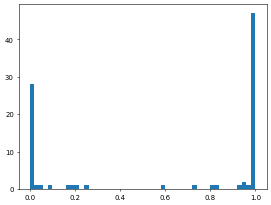

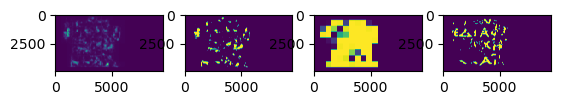

	 score:0.4156(th=0.150000), auc=0.908820, auc class=0.835714 ::: time:2464.93s


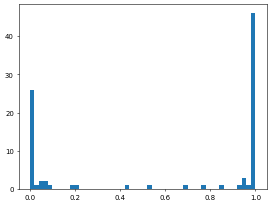

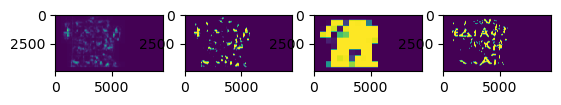

	 score:0.4099(th=0.150000), auc=0.906542, auc class=0.852143 ::: time:2483.95s


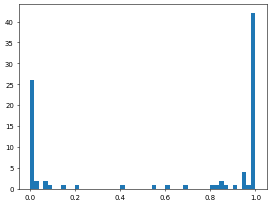

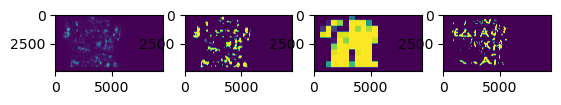

	 score:0.3737(th=0.100000), auc=0.899343, auc class=0.822143 ::: time:2502.70s
slide pos:[256, 0]


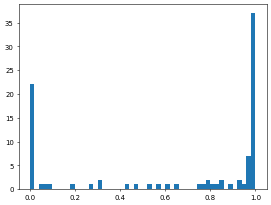

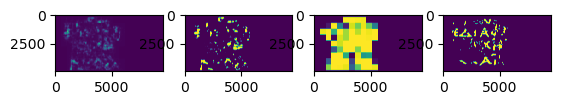

	 score:0.4194(th=0.150000), auc=0.902087, auc class=0.695586 ::: time:2522.50s


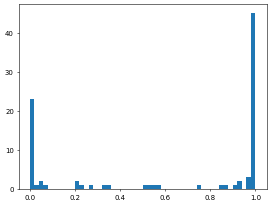

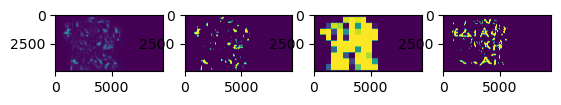

	 score:0.4092(th=0.200000), auc=0.893350, auc class=0.683409 ::: time:2542.32s


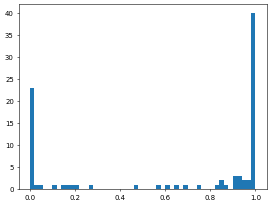

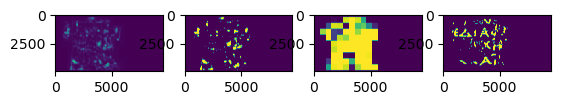

	 score:0.3987(th=0.150000), auc=0.890150, auc class=0.722983 ::: time:2561.50s
slide pos:[0, 256]


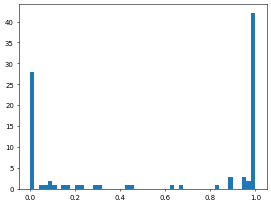

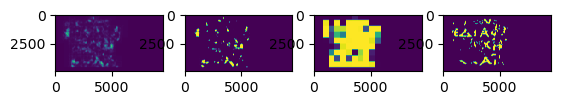

	 score:0.4682(th=0.200000), auc=0.902003, auc class=0.885747 ::: time:2580.61s


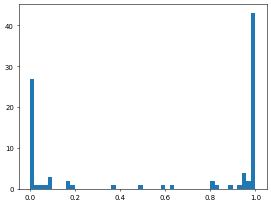

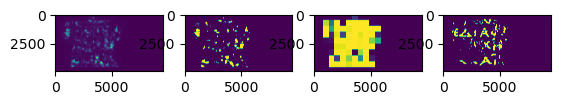

	 score:0.4272(th=0.150000), auc=0.900576, auc class=0.882919 ::: time:2599.79s


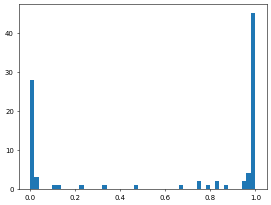

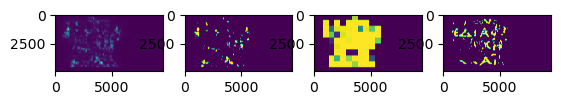

	 score:0.4282(th=0.200000), auc=0.894358, auc class=0.876697 ::: time:2619.00s
slide pos:[256, 256]


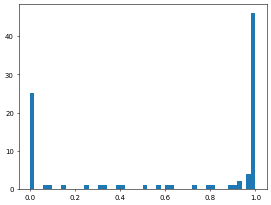

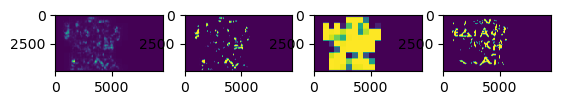

	 score:0.4459(th=0.200000), auc=0.896157, auc class=0.795833 ::: time:2638.42s


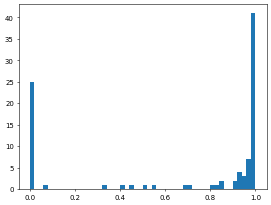

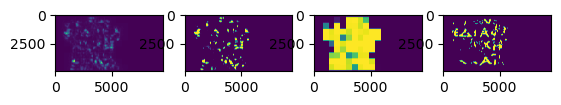

	 score:0.4322(th=0.150000), auc=0.888710, auc class=0.806548 ::: time:2658.29s


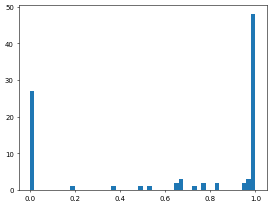

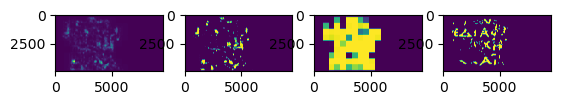

	 score:0.4061(th=0.150000), auc=0.889881, auc class=0.827976 ::: time:2677.59s
surface_list: [27, 30, 33, 36]
slide pos:[0, 0]


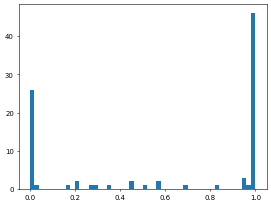

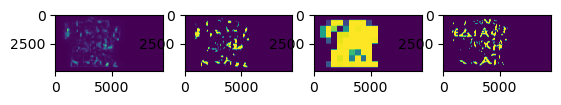

	 score:0.4639(th=0.150000), auc=0.917066, auc class=0.843571 ::: time:2700.22s


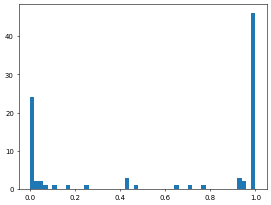

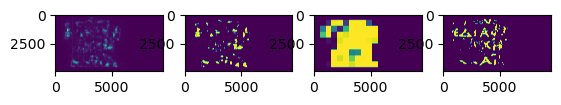

	 score:0.4353(th=0.150000), auc=0.913940, auc class=0.836429 ::: time:2719.52s


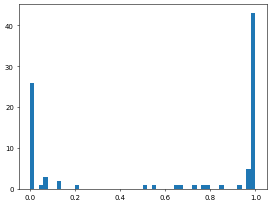

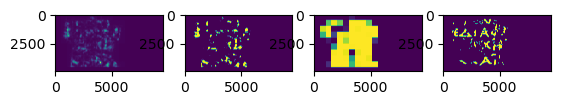

	 score:0.4187(th=0.150000), auc=0.909067, auc class=0.843571 ::: time:2739.27s
slide pos:[256, 0]


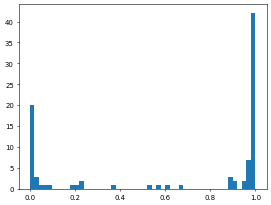

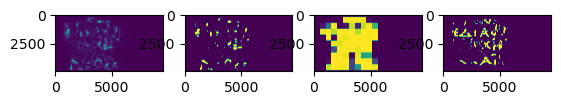

	 score:0.4520(th=0.200000), auc=0.910387, auc class=0.705479 ::: time:2758.67s


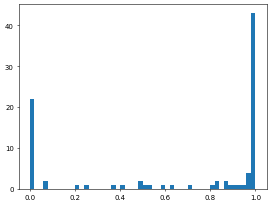

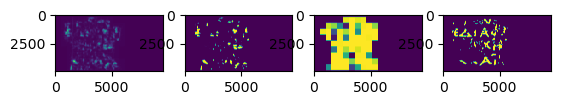

	 score:0.4322(th=0.200000), auc=0.903895, auc class=0.702435 ::: time:2778.08s


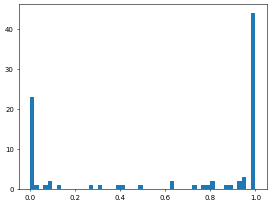

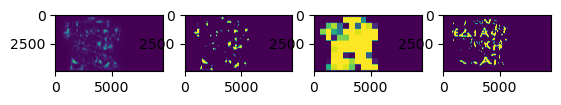

	 score:0.4218(th=0.200000), auc=0.896940, auc class=0.744292 ::: time:2797.66s
slide pos:[0, 256]


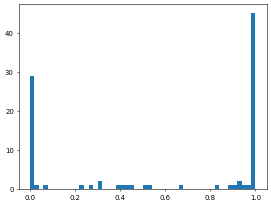

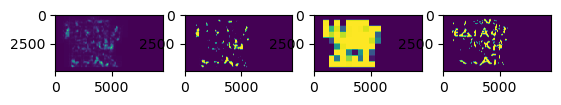

	 score:0.4996(th=0.200000), auc=0.914706, auc class=0.878394 ::: time:2816.67s


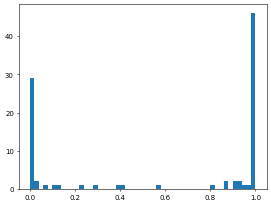

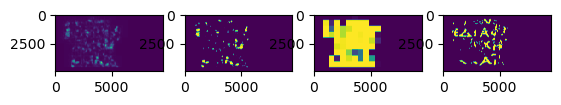

	 score:0.4439(th=0.200000), auc=0.909242, auc class=0.876131 ::: time:2835.60s


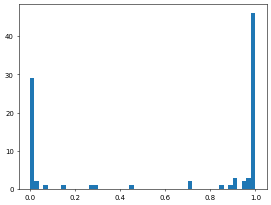

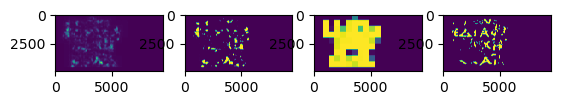

	 score:0.4590(th=0.150000), auc=0.909888, auc class=0.880090 ::: time:2854.94s
slide pos:[256, 256]


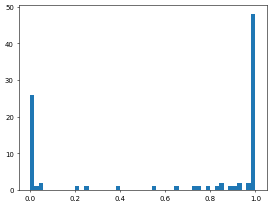

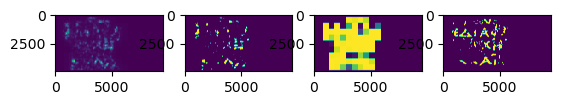

	 score:0.4628(th=0.200000), auc=0.906368, auc class=0.805952 ::: time:2874.24s


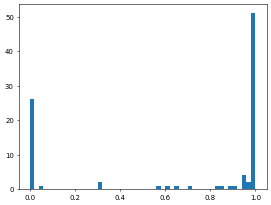

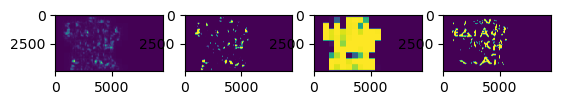

	 score:0.4361(th=0.200000), auc=0.904728, auc class=0.810714 ::: time:2893.68s


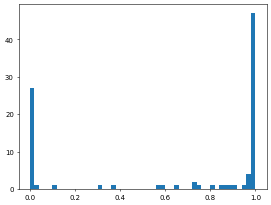

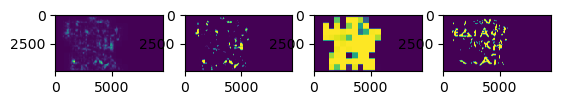

	 score:0.4375(th=0.200000), auc=0.896725, auc class=0.837500 ::: time:2912.81s
surface_list: [25, 28, 31, 34]
slide pos:[0, 0]


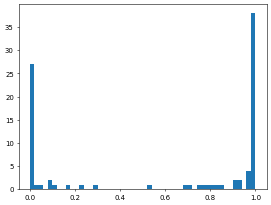

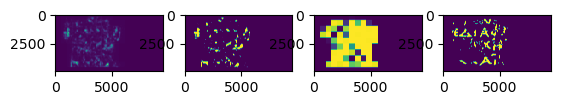

	 score:0.4122(th=0.150000), auc=0.900911, auc class=0.830714 ::: time:2935.76s


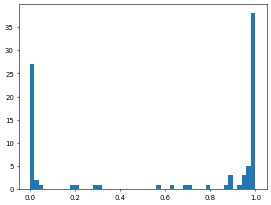

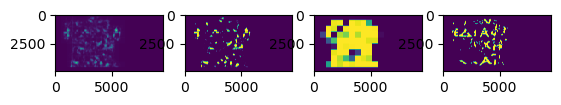

	 score:0.4283(th=0.150000), auc=0.905197, auc class=0.846429 ::: time:2954.80s


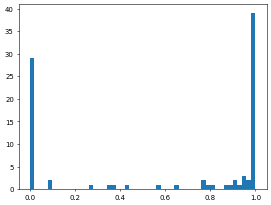

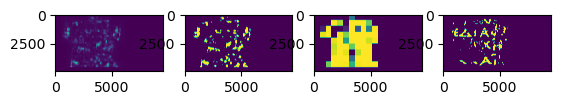

	 score:0.3536(th=0.100000), auc=0.898787, auc class=0.828571 ::: time:2974.08s
slide pos:[256, 0]


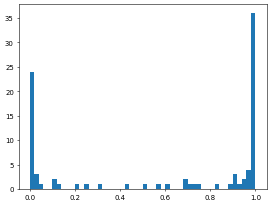

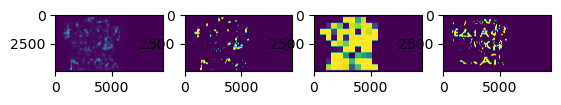

	 score:0.4214(th=0.200000), auc=0.890554, auc class=0.673516 ::: time:2993.30s


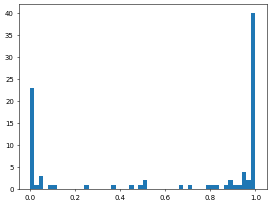

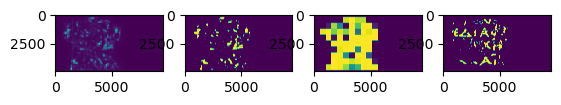

	 score:0.4199(th=0.150000), auc=0.890222, auc class=0.697108 ::: time:3012.96s


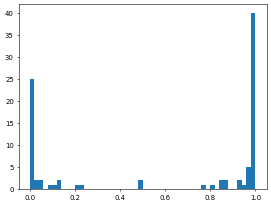

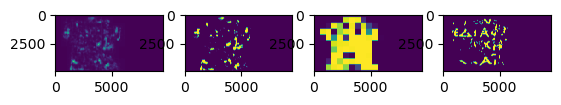

	 score:0.4024(th=0.150000), auc=0.885750, auc class=0.713851 ::: time:3032.32s
slide pos:[0, 256]


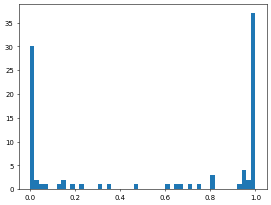

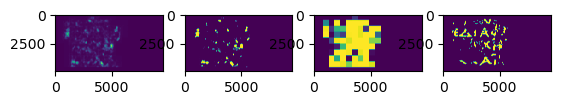

	 score:0.4318(th=0.200000), auc=0.890137, auc class=0.885747 ::: time:3051.61s


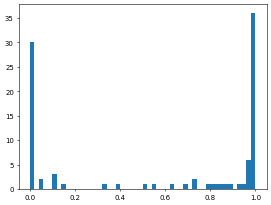

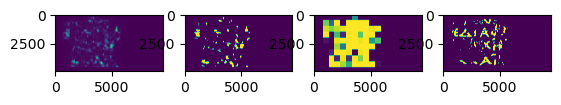

	 score:0.4365(th=0.150000), auc=0.898289, auc class=0.897624 ::: time:3071.06s


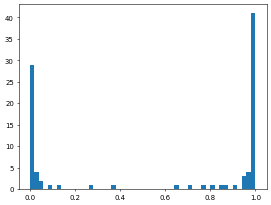

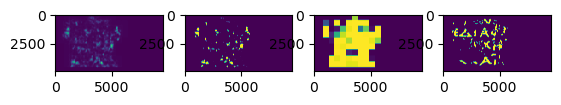

	 score:0.4090(th=0.200000), auc=0.889182, auc class=0.864253 ::: time:3090.56s
slide pos:[256, 256]


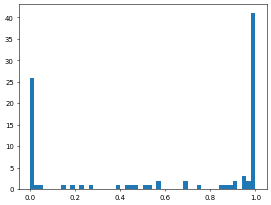

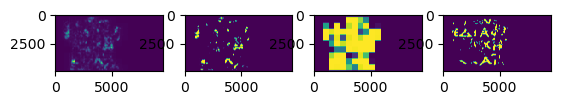

	 score:0.4322(th=0.200000), auc=0.884933, auc class=0.778571 ::: time:3110.42s


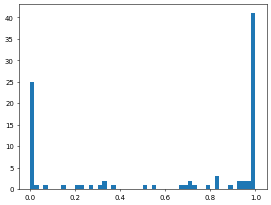

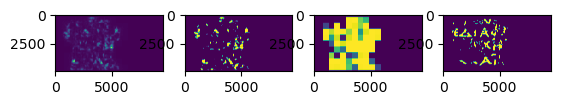

	 score:0.4389(th=0.150000), auc=0.885579, auc class=0.792262 ::: time:3129.98s


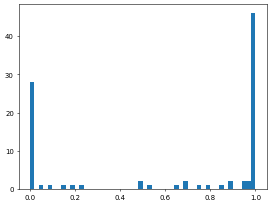

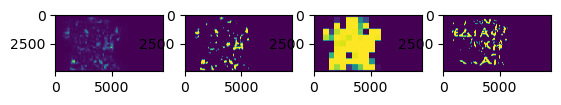

	 score:0.3914(th=0.150000), auc=0.882119, auc class=0.815476 ::: time:3149.42s


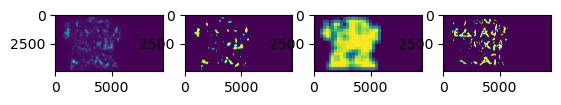

[fold3] slice ave score:0.4984(th=0.500000), auc=0.917048
-- fold4 slide inference start --
surface_list: [26, 29, 32, 35]
slide pos:[0, 0]


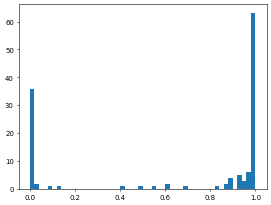

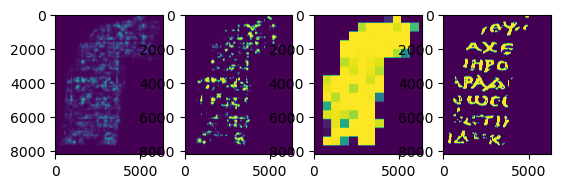

	 score:0.4342(th=0.200000), auc=0.869158, auc class=0.809949 ::: time:3207.86s


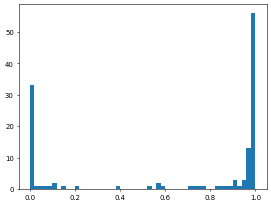

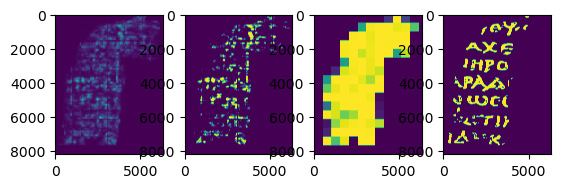

	 score:0.4269(th=0.200000), auc=0.868083, auc class=0.805166 ::: time:3231.12s


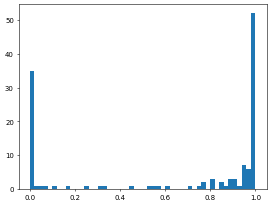

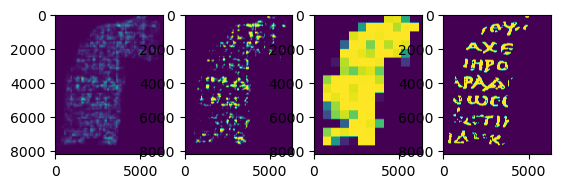

	 score:0.4075(th=0.200000), auc=0.861900, auc class=0.759566 ::: time:3254.25s
slide pos:[256, 0]


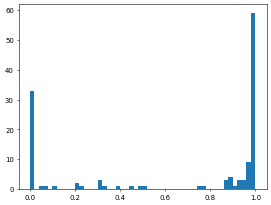

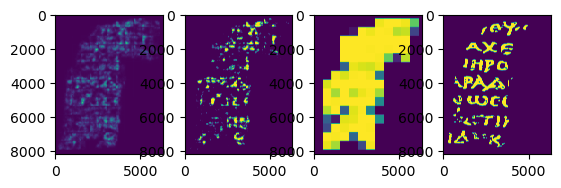

	 score:0.4376(th=0.200000), auc=0.861982, auc class=0.814881 ::: time:3277.52s


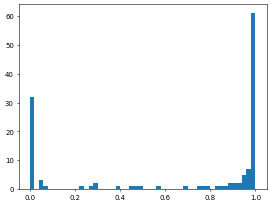

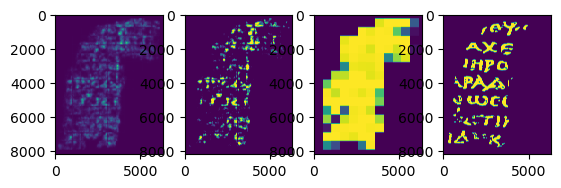

	 score:0.4300(th=0.200000), auc=0.855804, auc class=0.795833 ::: time:3300.81s


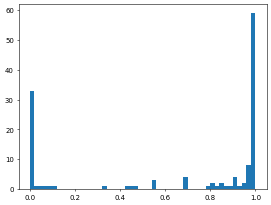

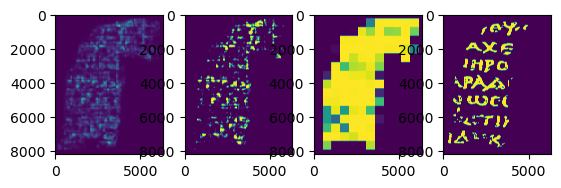

	 score:0.3935(th=0.200000), auc=0.856785, auc class=0.791369 ::: time:3323.89s
slide pos:[0, 256]


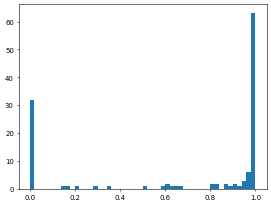

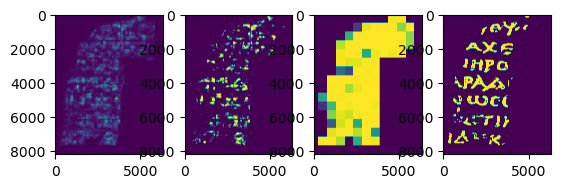

	 score:0.4235(th=0.200000), auc=0.870274, auc class=0.791181 ::: time:3347.39s


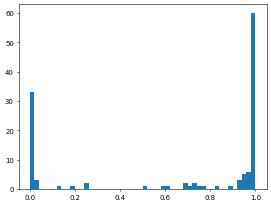

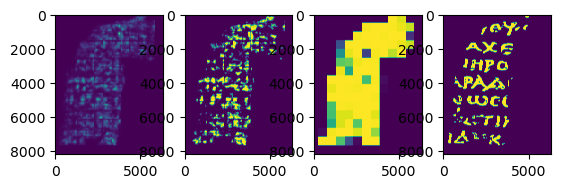

	 score:0.4147(th=0.150000), auc=0.869847, auc class=0.805758 ::: time:3370.50s


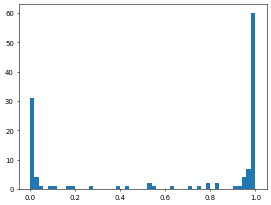

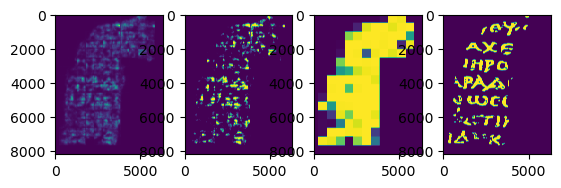

	 score:0.4163(th=0.200000), auc=0.864088, auc class=0.771137 ::: time:3393.45s
slide pos:[256, 256]


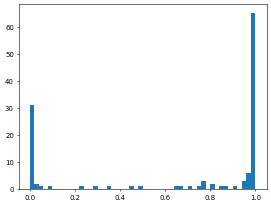

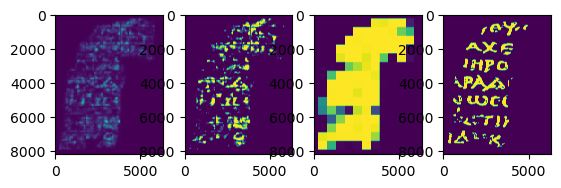

	 score:0.4282(th=0.150000), auc=0.865433, auc class=0.793459 ::: time:3416.72s


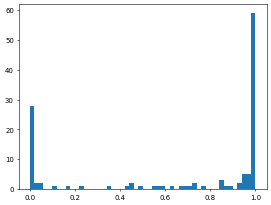

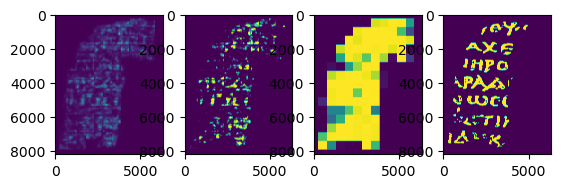

	 score:0.4061(th=0.200000), auc=0.857204, auc class=0.778528 ::: time:3439.68s


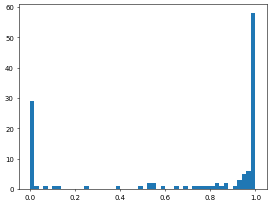

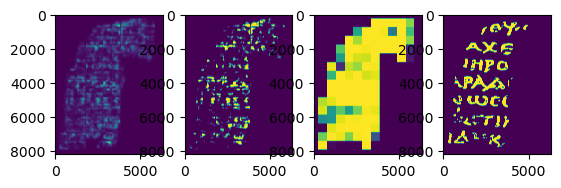

	 score:0.4073(th=0.200000), auc=0.857927, auc class=0.771418 ::: time:3462.76s
surface_list: [27, 30, 33, 36]
slide pos:[0, 0]


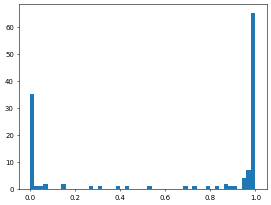

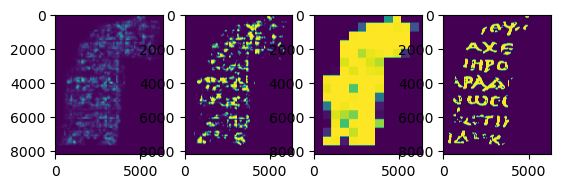

	 score:0.4358(th=0.150000), auc=0.872066, auc class=0.803890 ::: time:3500.71s


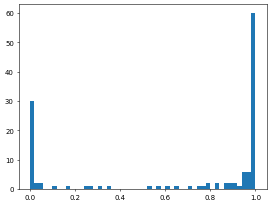

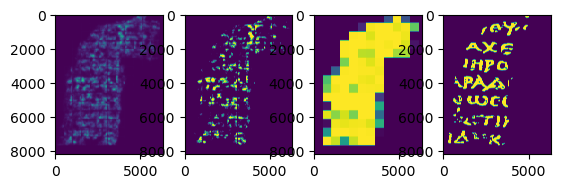

	 score:0.4251(th=0.200000), auc=0.866937, auc class=0.814094 ::: time:3524.55s


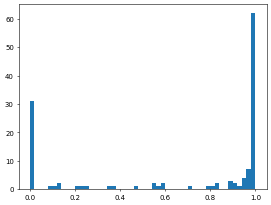

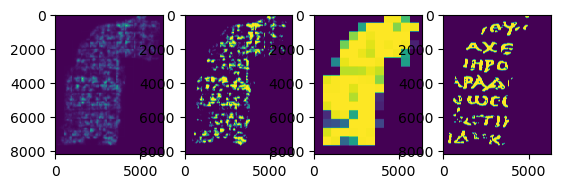

	 score:0.4088(th=0.150000), auc=0.866070, auc class=0.776148 ::: time:3547.66s
slide pos:[256, 0]


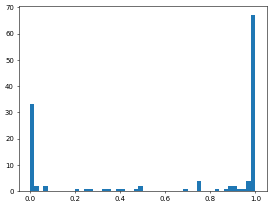

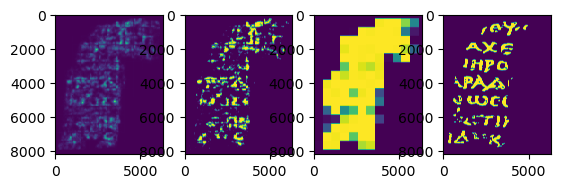

	 score:0.4270(th=0.150000), auc=0.864410, auc class=0.827083 ::: time:3570.96s


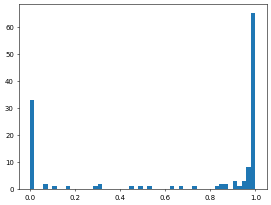

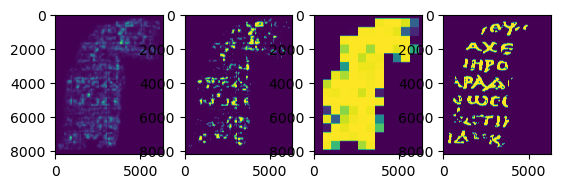

	 score:0.4229(th=0.200000), auc=0.857326, auc class=0.823810 ::: time:3593.98s


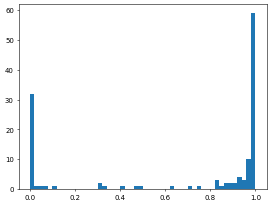

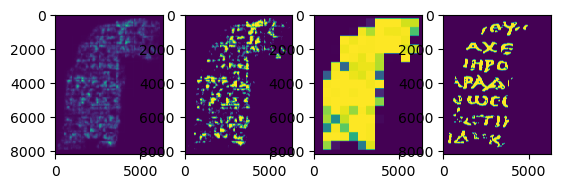

	 score:0.4009(th=0.150000), auc=0.859558, auc class=0.808929 ::: time:3617.60s
slide pos:[0, 256]


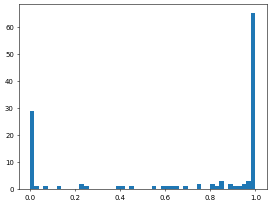

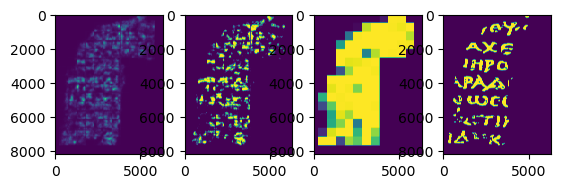

	 score:0.4297(th=0.150000), auc=0.871999, auc class=0.764577 ::: time:3640.66s


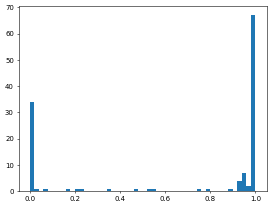

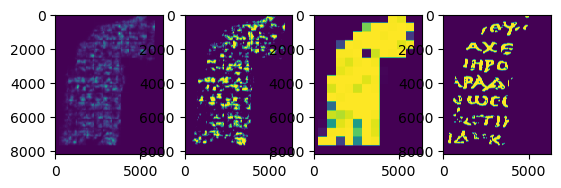

	 score:0.3987(th=0.150000), auc=0.865321, auc class=0.787536 ::: time:3663.69s


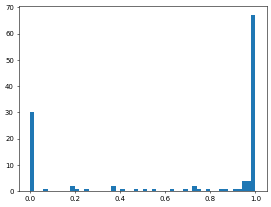

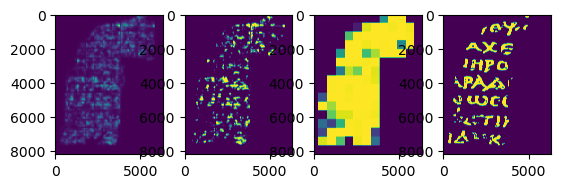

	 score:0.4097(th=0.200000), auc=0.863624, auc class=0.758382 ::: time:3686.54s
slide pos:[256, 256]


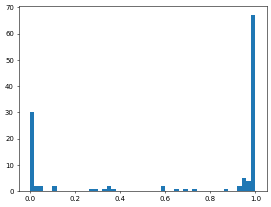

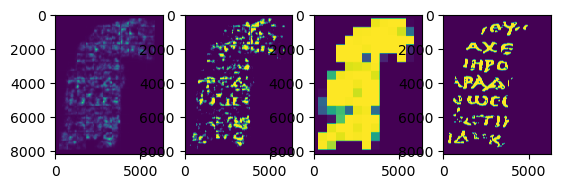

	 score:0.4256(th=0.150000), auc=0.866905, auc class=0.756488 ::: time:3709.62s


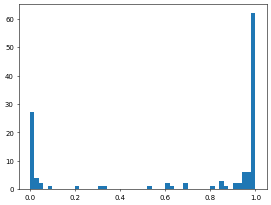

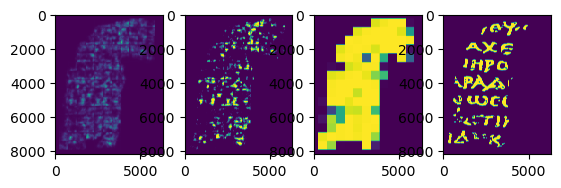

	 score:0.3995(th=0.200000), auc=0.858005, auc class=0.777817 ::: time:3732.49s


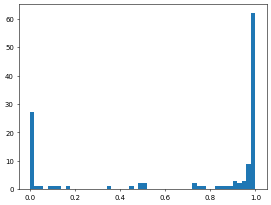

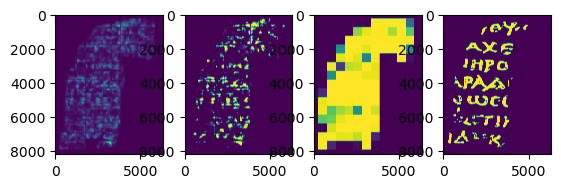

	 score:0.4121(th=0.200000), auc=0.860306, auc class=0.775329 ::: time:3755.57s
surface_list: [25, 28, 31, 34]
slide pos:[0, 0]


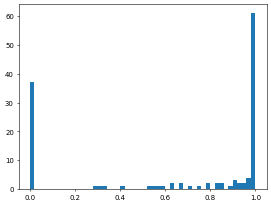

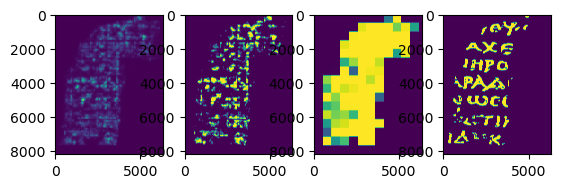

	 score:0.4130(th=0.150000), auc=0.863954, auc class=0.795599 ::: time:3791.40s


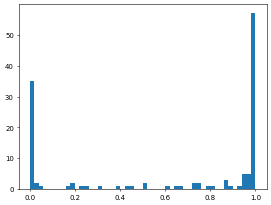

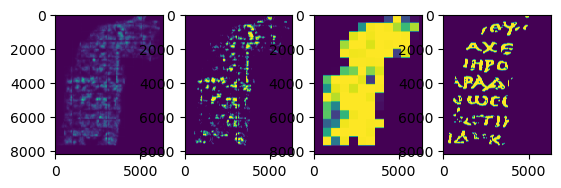

	 score:0.4092(th=0.200000), auc=0.861246, auc class=0.801977 ::: time:3816.14s


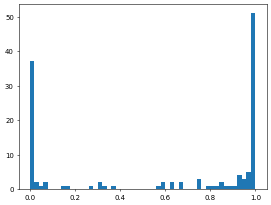

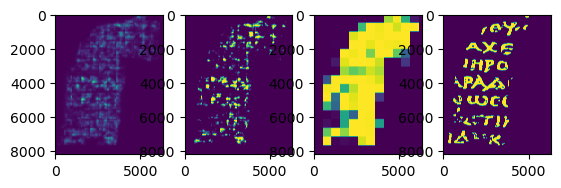

	 score:0.3906(th=0.200000), auc=0.852885, auc class=0.760204 ::: time:3839.98s
slide pos:[256, 0]


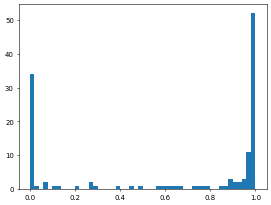

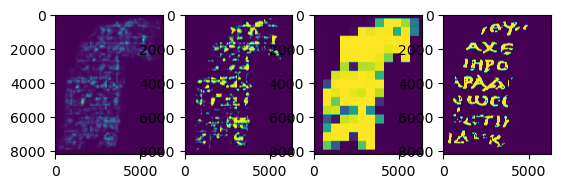

	 score:0.4167(th=0.150000), auc=0.857199, auc class=0.813393 ::: time:3863.38s


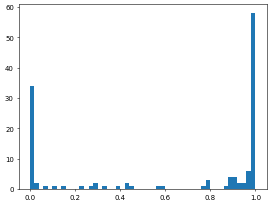

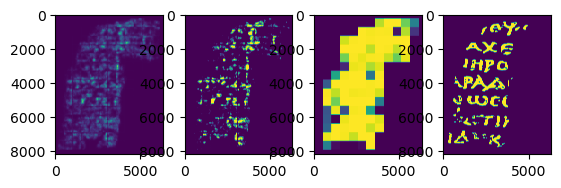

	 score:0.4124(th=0.200000), auc=0.852247, auc class=0.796131 ::: time:3887.06s


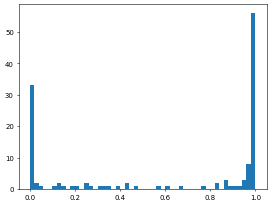

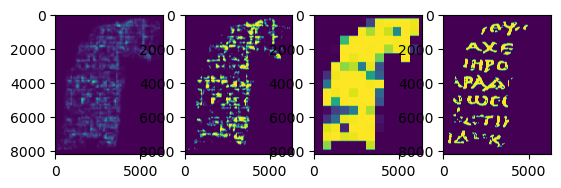

	 score:0.3733(th=0.150000), auc=0.851536, auc class=0.794792 ::: time:3910.49s
slide pos:[0, 256]


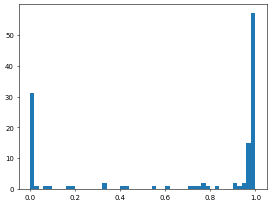

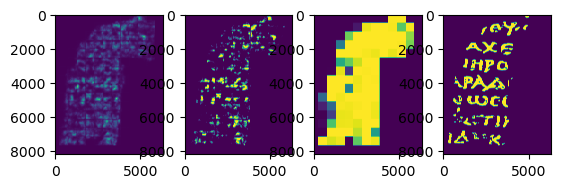

	 score:0.4151(th=0.200000), auc=0.864557, auc class=0.793732 ::: time:3933.43s


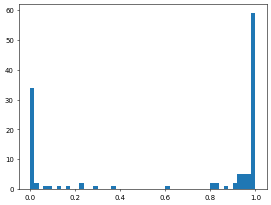

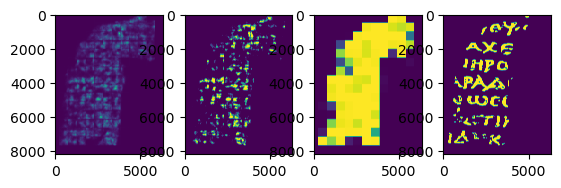

	 score:0.4040(th=0.200000), auc=0.865625, auc class=0.813411 ::: time:3956.41s


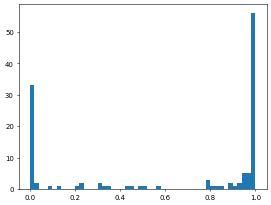

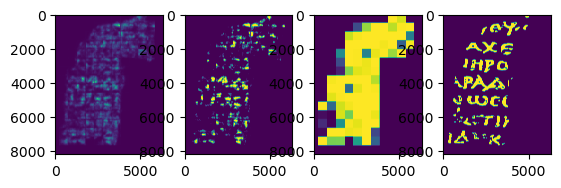

	 score:0.3966(th=0.200000), auc=0.856961, auc class=0.776603 ::: time:3979.43s
slide pos:[256, 256]


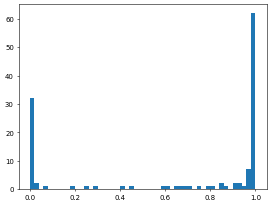

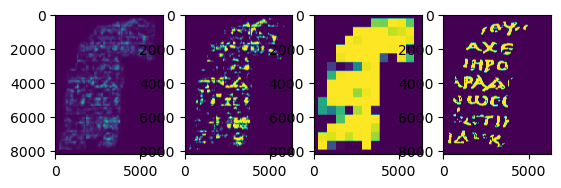

	 score:0.4128(th=0.150000), auc=0.859900, auc class=0.766797 ::: time:4002.30s


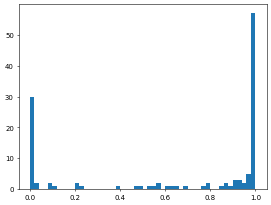

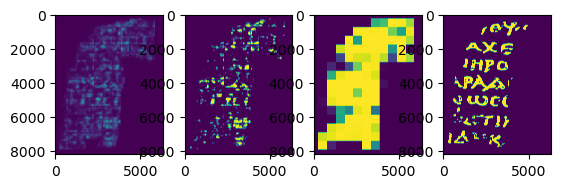

	 score:0.3961(th=0.200000), auc=0.853991, auc class=0.751866 ::: time:4025.15s


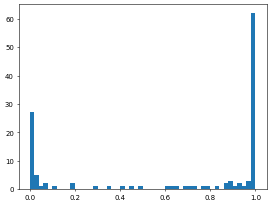

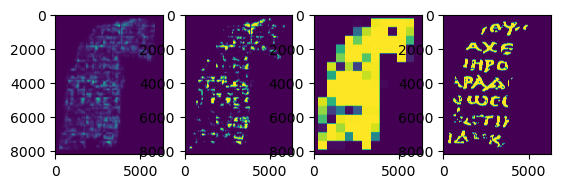

	 score:0.3791(th=0.200000), auc=0.851984, auc class=0.777106 ::: time:4047.48s


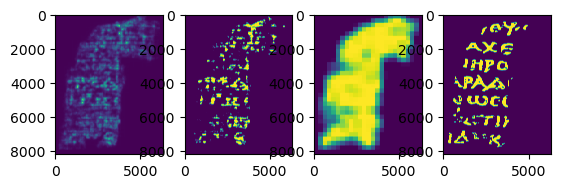

[fold4] slice ave score:0.4723(th=0.500000), auc=0.878712
fold[0] slice ave score:0.5754(th=0.450000), auc=0.906707
fold[1] slice ave score:0.5223(th=0.600000), auc=0.842096
fold[2] slice ave score:0.5191(th=0.450000), auc=0.845156
fold[3] slice ave score:0.4984(th=0.500000), auc=0.917048
fold[4] slice ave score:0.4723(th=0.500000), auc=0.878712
CPU times: user 56min 37s, sys: 16min 11s, total: 1h 12min 49s
Wall time: 1h 7min 46s


In [31]:
%%time
tta_list = ["default", "hflip", "vflip"]
slice_ave_score_list, slice_ave_auc_list, slice_ave_score_threshold_list = slide_inference(CFG, tta_list)
for fold in CFG["folds"]:
    print(f"fold[{fold}] slice ave score:{slice_ave_score_list[fold]:.4f}(th={slice_ave_score_threshold_list[fold]:3f}), auc={slice_ave_auc_list[fold]:4f}")


/working/output/exp057/imgs/fold0_average_class_slice555_valid_pred_img.png
(7606, 5249)
(7606, 5249)


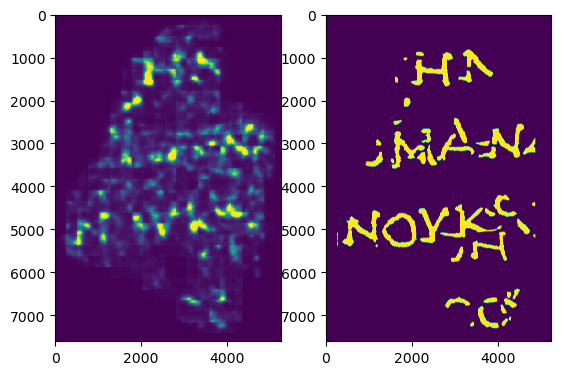

/working/output/exp057/imgs/fold1_average_class_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


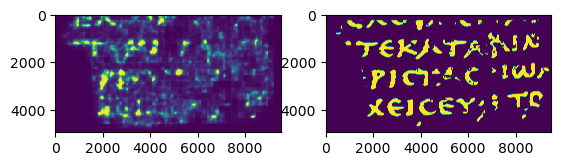

/working/output/exp057/imgs/fold2_average_class_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


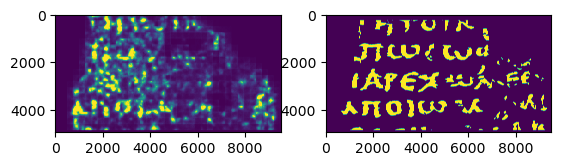

/working/output/exp057/imgs/fold3_average_class_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


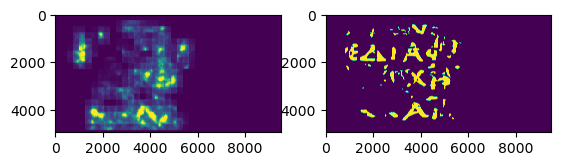

/working/output/exp057/imgs/fold4_average_class_slice555_valid_pred_img.png
(8181, 6330)
(8181, 6330)


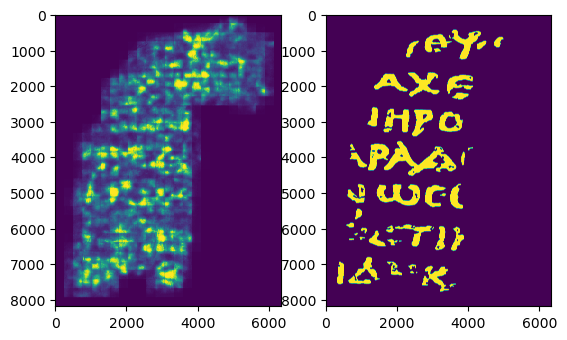

CPU times: user 17.8 s, sys: 7.34 s, total: 25.2 s
Wall time: 25.9 s


In [ ]:
%%time
pred_flatten_list = []
mask_flatten_list = []
for fold in [0,1,2,3,4]:
    pred_path = os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_average_class_slice555_valid_pred_img.png")
    mask_path = os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_average_class_slice555_valid_targets_img.png")
    print(pred_path)
    pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    print(pred_img.shape)
    print(mask_img.shape)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(pred_img)
    plt.subplot(1, 2, 2)
    plt.imshow(mask_img)
    plt.show()
    pred_flatten_list.extend(pred_img.flatten())
    mask_flatten_list.extend(mask_img.flatten())

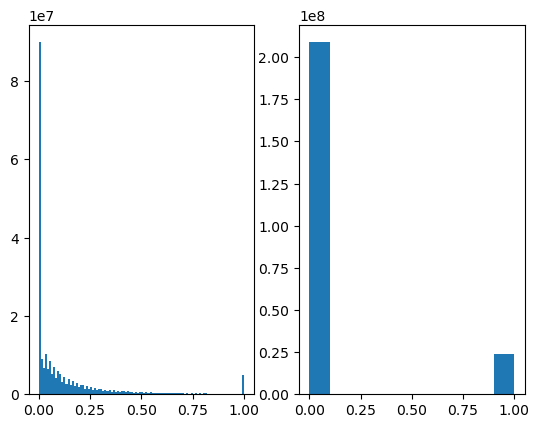

th=0.10, dice=0.2854
th=0.15, dice=0.3251
th=0.20, dice=0.3557
th=0.25, dice=0.3841
th=0.30, dice=0.4077
th=0.35, dice=0.4264
th=0.40, dice=0.4400
th=0.45, dice=0.4507
th=0.50, dice=0.4582
th=0.55, dice=0.4623
th=0.60, dice=0.4633
th=0.65, dice=0.4615
th=0.70, dice=0.4570
th=0.75, dice=0.4500
th=0.80, dice=0.4417
th=0.85, dice=0.4311
th=0.90, dice=0.4189
th=0.95, dice=0.4054
th=1.00, dice=0.3918


In [ ]:
mask_flatten_list = np.array(mask_flatten_list)/255.
mask = np.array(mask_flatten_list).astype(int)
pred = np.array(pred_flatten_list)/255.

plt.figure()
plt.subplot(1, 2, 1)
plt.hist(pred, bins=100)
plt.subplot(1, 2, 2)
plt.hist(mask)
plt.show()

for th in np.array(range(10, 100+1, 5)) / 100:
    dice = fbeta_numpy(mask, (pred >= th).astype(int), beta=0.5)
    print(f"th={th:.2f}, dice={dice:.4f}")